In [17]:
import dask
from dask.distributed import Client

try:
    client
except NameError:
    print("No dask client defined, starting client")
    client = Client(n_workers=16, threads_per_worker=2, memory_limit='30GB')  # start distributed scheduler locally.
else:
    print("Dask client already defined.")

# Display the client details to confirm it's running
client

No dask client defined, starting client


<Client: 'tcp://127.0.0.1:56005' processes=16 threads=32, memory=447.03 GiB>

In [18]:
import dask.dataframe as dd
import pandas as pd
import os

print(f'Dask version: {dask.__version__}')
print(f'Pandas version: {pd.__version__}')

# Directory containing CSV files
directory = r'data'

# Define standard columns and data types
standard_columns = [
    'MAC', 'Unix_time_Stamp', 'Date', 'Temp', 'Temp_sym', 
    'Humidity', 'Humidity_sym', 'Pressure', 'Pressure_sym', 
    'IDs_1', 'ID_1', 'Weight_1', 'Wt_sym_1', 
    'IDs_2', 'ID_2', 'Weight_2', 'Wt_sym_2', 
    'IDs_3', 'ID_3', 'Weight_3', 'Wt_sym_3', 
    'IDs_4', 'ID_4', 'Weight_4', 'Wt_sym_4', 
    'IDs_5', 'ID_5', 'Weight_5', 'Wt_sym_5'
]

# Define dtypes
dtypes = {
    'MAC': 'string',
    'Unix_time_Stamp': 'uint64',
    'Temp': 'float64',
    'Temp_sym': 'string',
    'Humidity': 'float64',
    'Humidity_sym': 'string',
    'Pressure': 'int64',
    'Pressure_sym': 'string',
    'IDs_1': 'string',
    'ID_1': 'int64',
    'Weight_1': 'int64',
    'Wt_sym_1': 'string', 
    'IDs_2': 'string',
    'ID_2': 'int64',
    'Weight_2': 'int64',
    'Wt_sym_2': 'string', 
    'IDs_3': 'string',
    'ID_3': 'int64',
    'Weight_3': 'int64',
    'Wt_sym_3': 'string', 
    'IDs_4': 'string',
    'ID_4': 'int64',
    'Weight_4': 'int64',
    'Wt_sym_4': 'string', 
    'IDs_5': 'string',
    'ID_5': 'int64',
    'Weight_5': 'int64',
    'Wt_sym_5': 'string'
}

# List all CSV files in the directory
csv_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]

# Read all CSV files with Dask
ddf = dd.read_csv(csv_files, header=None, assume_missing=True)

# Rename columns and reorder
ddf = ddf.rename(columns=dict(enumerate(standard_columns)))
ddf = ddf[[col for col in standard_columns if col in ddf.columns]]

# Convert data types
for col, dtype in dtypes.items():
    if dtype == 'int64':
        ddf[col] = dd.to_numeric(ddf[col], errors='coerce').astype('Int64')
    elif dtype == 'float64':
        ddf[col] = dd.to_numeric(ddf[col], errors='coerce').astype('float64')
    else:
        ddf[col] = ddf[col].astype(dtype)

# Convert Pressure to float64 and divide by 1000
ddf['Pressure'] = (ddf['Pressure'] / 1000).astype('float64')
print("4")
# Compute the DataFrame (trigger computation)
combined_df = ddf.compute()
print("5")
# Display the first few rows
display(combined_df.head())


# Identify log events or incorrect entries
log_event_stopped_df = combined_df[combined_df['Pressure_sym'].str.contains('Log event stopped', na=False)]

log_event_start_df = combined_df[combined_df['Pressure_sym'].str.contains('Log event started', na=False)]

# Assume that any row without a standard number of columns or containing 'Log event started' is incorrect
incorrect_entries_df = combined_df[combined_df['Pressure_sym'].str.contains('Log event started', na=False) | (combined_df['Weight_1'].isna())]

# Extract rows that fit the correct structure (excluding log events)
correct_entries_df = combined_df[~combined_df.index.isin(incorrect_entries_df.index)]


import matplotlib.pyplot as plt

# Display the first few rows of each DataFrame
print("Log Event Starts:")
display(log_event_start_df.head())

print("Log Event Stopped:")
display(log_event_stopped_df.head())


print("Incorrect Entries:")
display(incorrect_entries_df.head())

print("Correct Entries:")
display(correct_entries_df.head())

# Optional: Save these DataFrames to separate CSV files for further analysis
log_event_start_df.to_csv('log_event_starts.csv', index=False)
log_event_stopped_df.to_csv('log_event_stopped.csv', index=False)
incorrect_entries_df.to_csv('incorrect_entries.csv', index=False)
correct_entries_df.to_csv('correct_entries.csv', index=False)


Dask version: 2024.5.0
Pandas version: 2.2.2
4
5


MAC  Unix_time_Stamp                  Date  Temp Temp_sym  \
0  7C:DF:A1:E0:91:AC       1674573949  2023-01-24T15:25:49Z  22.2        C   
1  7C:DF:A1:E0:91:AC       1674573949  2023-01-24T15:25:49Z  22.2        C   
2  7C:DF:A1:E0:91:AC       1674574200  2023-01-24T15:30:00Z  22.1        C   
3  7C:DF:A1:E0:91:AC       1674576000  2023-01-24T16:00:00Z  22.1        C   
4  7C:DF:A1:E0:91:AC       1674577800  2023-01-24T16:30:00Z  21.1        C   

   Humidity Humidity_sym  Pressure           Pressure_sym IDs_1  ID_1  \
0      30.0            %    96.121  hPaLog event started.  <NA>  <NA>   
1      30.0            %    96.121                    hPa    id     1   
2      30.7            %    96.144                    hPa    id     1   
3      29.1            %    96.272                    hPa    id     1   
4      29.6            %    96.379                    hPa    id     1   

   Weight_1 Wt_sym_1 IDs_2  ID_2  Weight_2 Wt_sym_2 IDs_3  ID_3  Weight_3  \
0      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
1       824        g    id     2       171        g    id     3       580   
2       820        g    id     2       170        g    id     3       579   
3       817        g    id     2       169        g    id     3       576   
4       814        g    id     2       169        g    id     3       573   

  Wt_sym_3 IDs_4  ID_4  Weight_4 Wt_sym_4 IDs_5  ID_5  Weight_5 Wt_sym_5  
0     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
1        g    id     4       517        g    id     5       399        g  
2        g    id     4       516        g    id     5       399        g  
3        g    id     4       512        g    id     5       398        g  
4        g    id     4       509        g    id     5       397        g

Log Event Starts:


MAC  Unix_time_Stamp                  Date  Temp Temp_sym  \
0   7C:DF:A1:E0:91:AC       1674573949  2023-01-24T15:25:49Z  22.2        C   
20  7C:DF:A1:E0:91:AC       1675675800  2023-02-06T09:15:00Z  18.8        C   
40  7C:DF:A1:E0:91:AC       1679082025  2023-03-17T19:40:25Z  20.9        C   
20  7C:DF:A1:E0:91:AC       1679995436  2023-03-28T09:23:56Z  20.4        C   
41  7C:DF:A1:E0:91:AC       1682280615  2023-04-23T20:10:15Z  20.7        C   

    Humidity Humidity_sym  Pressure           Pressure_sym IDs_1  ID_1  \
0       30.0            %    96.121  hPaLog event started.  <NA>  <NA>   
20      25.9            %    98.905  hPaLog event started.  <NA>  <NA>   
40      27.0            %    97.688  hPaLog event started.  <NA>  <NA>   
20      28.1            %    98.778  hPaLog event started.  <NA>  <NA>   
41      31.6            %    99.950  hPaLog event started.  <NA>  <NA>   

    Weight_1 Wt_sym_1 IDs_2  ID_2  Weight_2 Wt_sym_2 IDs_3  ID_3  Weight_3  \
0       <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
20      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
40      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
20      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
41      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   

   Wt_sym_3 IDs_4  ID_4  Weight_4 Wt_sym_4 IDs_5  ID_5  Weight_5 Wt_sym_5  
0      <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
20     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
40     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
20     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
41     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>

Log Event Stopped:


MAC  Unix_time_Stamp                  Date  Temp Temp_sym  \
19  7C:DF:A1:E0:91:AC       1675675800  2023-02-06T09:10:00Z  18.8        C   
24  7C:DF:A1:E0:91:AC       1676462400  2023-02-15T12:00:00Z  19.0        C   
19  6C:DF:A1:E0:91:AC       1679995435  2023-03-28T09:13:56Z  19.4        C   
43  6C:DF:A1:E0:91:AC       1680989399  2023-04-08T21:30:00Z  18.4        C   
23  7C:DF:A1:E0:91:AC       1683630882  2023-05-09T11:14:42Z  21.3        C   

    Humidity Humidity_sym  Pressure           Pressure_sym IDs_1  ID_1  \
19      25.9            %    98.905  hPaLog event stopped.  <NA>  <NA>   
24      21.9            %    99.049  hPaLog event stopped.    id     1   
19      27.1            %    98.777  hPaLog event stopped.  <NA>  <NA>   
43      22.1            %    98.951  hPaLog event stopped.  <NA>  <NA>   
23      27.4            %    96.955  hPaLog event stopped.  <NA>  <NA>   

    Weight_1 Wt_sym_1 IDs_2  ID_2  Weight_2 Wt_sym_2 IDs_3  ID_3  Weight_3  \
19      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
24         0        g    id     2         3        g    id     3         2   
19      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
43      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
23      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   

   Wt_sym_3 IDs_4  ID_4  Weight_4 Wt_sym_4 IDs_5  ID_5  Weight_5 Wt_sym_5  
19     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
24        g    id     4        -2        g    id     5         1        g  
19     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
43     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
23     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>

Incorrect Entries:


MAC  Unix_time_Stamp                  Date  Temp Temp_sym  \
0   7C:DF:A1:E0:91:AC       1674573949  2023-01-24T15:25:49Z  22.2        C   
19  7C:DF:A1:E0:91:AC       1675675800  2023-02-06T09:10:00Z  18.8        C   
20  7C:DF:A1:E0:91:AC       1675675800  2023-02-06T09:15:00Z  18.8        C   
40  7C:DF:A1:E0:91:AC       1679082025  2023-03-17T19:40:25Z  20.9        C   
19  6C:DF:A1:E0:91:AC       1679995435  2023-03-28T09:13:56Z  19.4        C   

    Humidity Humidity_sym  Pressure           Pressure_sym IDs_1  ID_1  \
0       30.0            %    96.121  hPaLog event started.  <NA>  <NA>   
19      25.9            %    98.905  hPaLog event stopped.  <NA>  <NA>   
20      25.9            %    98.905  hPaLog event started.  <NA>  <NA>   
40      27.0            %    97.688  hPaLog event started.  <NA>  <NA>   
19      27.1            %    98.777  hPaLog event stopped.  <NA>  <NA>   

    Weight_1 Wt_sym_1 IDs_2  ID_2  Weight_2 Wt_sym_2 IDs_3  ID_3  Weight_3  \
0       <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
19      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
20      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
40      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
19      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   

   Wt_sym_3 IDs_4  ID_4  Weight_4 Wt_sym_4 IDs_5  ID_5  Weight_5 Wt_sym_5  
0      <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
19     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
20     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
40     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
19     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>

Correct Entries:


MAC  Unix_time_Stamp                  Date  Temp Temp_sym  \
2  7C:DF:A1:E0:91:AC       1674574200  2023-01-24T15:30:00Z  22.1        C   
3  7C:DF:A1:E0:91:AC       1674576000  2023-01-24T16:00:00Z  22.1        C   
4  7C:DF:A1:E0:91:AC       1674577800  2023-01-24T16:30:00Z  21.1        C   
5  7C:DF:A1:E0:91:AC       1674579600  2023-01-24T17:00:00Z  20.6        C   
6  7C:DF:A1:E0:91:AC       1674581400  2023-01-24T17:30:00Z  20.2        C   

   Humidity Humidity_sym  Pressure Pressure_sym IDs_1  ID_1  Weight_1  \
2      30.7            %    96.144          hPa    id     1       820   
3      29.1            %    96.272          hPa    id     1       817   
4      29.6            %    96.379          hPa    id     1       814   
5      29.8            %    96.458          hPa    id     1       812   
6      30.5            %    96.552          hPa    id     1       809   

  Wt_sym_1 IDs_2  ID_2  Weight_2 Wt_sym_2 IDs_3  ID_3  Weight_3 Wt_sym_3  \
2        g    id     2       170        g    id     3       579        g   
3        g    id     2       169        g    id     3       576        g   
4        g    id     2       169        g    id     3       573        g   
5        g    id     2       169        g    id     3       571        g   
6        g    id     2       168        g    id     3       568        g   

  IDs_4  ID_4  Weight_4 Wt_sym_4 IDs_5  ID_5  Weight_5 Wt_sym_5  
2    id     4       516        g    id     5       399        g  
3    id     4       512        g    id     5       398        g  
4    id     4       509        g    id     5       397        g  
5    id     4       506        g    id     5       396        g  
6    id     4       504        g    id     5       395        g

In [19]:
# Print the first few rows of the combined DataFrame
print(combined_df.shape)
display(combined_df.head())
display(combined_df.tail())

(31146, 29)


MAC  Unix_time_Stamp                  Date  Temp Temp_sym  \
0  7C:DF:A1:E0:91:AC       1674573949  2023-01-24T15:25:49Z  22.2        C   
1  7C:DF:A1:E0:91:AC       1674573949  2023-01-24T15:25:49Z  22.2        C   
2  7C:DF:A1:E0:91:AC       1674574200  2023-01-24T15:30:00Z  22.1        C   
3  7C:DF:A1:E0:91:AC       1674576000  2023-01-24T16:00:00Z  22.1        C   
4  7C:DF:A1:E0:91:AC       1674577800  2023-01-24T16:30:00Z  21.1        C   

   Humidity Humidity_sym  Pressure           Pressure_sym IDs_1  ID_1  \
0      30.0            %    96.121  hPaLog event started.  <NA>  <NA>   
1      30.0            %    96.121                    hPa    id     1   
2      30.7            %    96.144                    hPa    id     1   
3      29.1            %    96.272                    hPa    id     1   
4      29.6            %    96.379                    hPa    id     1   

   Weight_1 Wt_sym_1 IDs_2  ID_2  Weight_2 Wt_sym_2 IDs_3  ID_3  Weight_3  \
0      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>   
1       824        g    id     2       171        g    id     3       580   
2       820        g    id     2       170        g    id     3       579   
3       817        g    id     2       169        g    id     3       576   
4       814        g    id     2       169        g    id     3       573   

  Wt_sym_3 IDs_4  ID_4  Weight_4 Wt_sym_4 IDs_5  ID_5  Weight_5 Wt_sym_5  
0     <NA>  <NA>  <NA>      <NA>     <NA>  <NA>  <NA>      <NA>     <NA>  
1        g    id     4       517        g    id     5       399        g  
2        g    id     4       516        g    id     5       399        g  
3        g    id     4       512        g    id     5       398        g  
4        g    id     4       509        g    id     5       397        g

MAC  Unix_time_Stamp                  Date  Temp Temp_sym  \
29  7C:DF:A1:E0:91:AC       1730644200  2024-11-03T14:30:00Z  20.9        C   
30  7C:DF:A1:E0:91:AC       1730646000  2024-11-03T15:00:00Z  20.9        C   
31  7C:DF:A1:E0:91:AC       1730647800  2024-11-03T15:30:00Z  21.1        C   
32  7C:DF:A1:E0:91:AC       1730649600  2024-11-03T16:00:00Z  21.0        C   
33  7C:DF:A1:E0:91:AC       1730651400  2024-11-03T16:30:00Z  21.0        C   

    Humidity Humidity_sym  Pressure           Pressure_sym IDs_1  ID_1  \
29      32.4            %    99.017                    hPa    id     1   
30      31.9            %    99.022                    hPa    id     1   
31      31.8            %    99.036                    hPa    id     1   
32      31.6            %    99.068                    hPa    id     1   
33      31.5            %    99.092  hPaLog event stopped.    id     1   

    Weight_1 Wt_sym_1 IDs_2  ID_2  Weight_2 Wt_sym_2 IDs_3  ID_3  Weight_3  \
29       365        g    id     2         6        g    id     3       337   
30       364        g    id     2         6        g    id     3       337   
31       364        g    id     2         6        g    id     3       337   
32       364        g    id     2         6        g    id     3       337   
33       364        g    id     2         6        g    id     3       337   

   Wt_sym_3 IDs_4  ID_4  Weight_4 Wt_sym_4 IDs_5  ID_5  Weight_5 Wt_sym_5  
29        g    id     4       -11        g    id     5         0        g  
30        g    id     4       -11        g    id     5         0        g  
31        g    id     4       -11        g    id     5         0        g  
32        g    id     4       -11        g    id     5         0        g  
33        g    id     4       -11        g    id     5         0        g

C:\Users\Neil\AppData\Local\Temp\ipykernel_4028\704754463.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_event_start_df['Date'] = pd.to_datetime(log_event_start_df['Date'])
C:\Users\Neil\AppData\Local\Temp\ipykernel_4028\704754463.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_event_stopped_df['Date'] = pd.to_datetime(log_event_stopped_df['Date'])


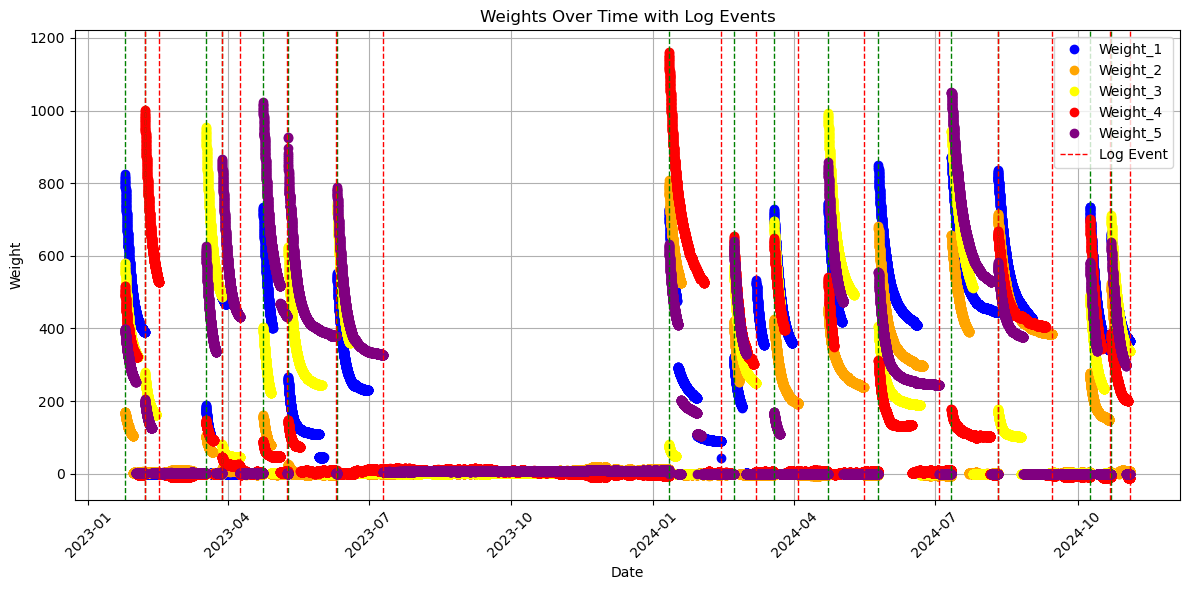

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
# Ensure 'Date' is a datetime column for proper plotting
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
filtered_df=combined_df
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
log_event_start_df['Date'] = pd.to_datetime(log_event_start_df['Date'])
log_event_stopped_df['Date'] = pd.to_datetime(log_event_stopped_df['Date'])


# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Date'], filtered_df['Weight_1'], marker='o', linestyle='', color='b', label='Weight_1')
plt.plot(filtered_df['Date'], filtered_df['Weight_2'], marker='o', linestyle='', color='orange', label='Weight_2')
plt.plot(filtered_df['Date'], filtered_df['Weight_3'], marker='o', linestyle='', color='yellow', label='Weight_3')
plt.plot(filtered_df['Date'], filtered_df['Weight_4'], marker='o', linestyle='', color='red', label='Weight_4')
plt.plot(filtered_df['Date'], filtered_df['Weight_5'], marker='o', linestyle='', color='purple', label='Weight_5')

# Add vertical lines for each entry in log_event_start_df
for log_date in log_event_start_df['Date']:
    plt.axvline(x=log_date, color='green', linestyle='--', linewidth=1, label='Log Event')

# Add vertical lines for each entry in log_event_start_df
for log_date in log_event_stopped_df['Date']:
    plt.axvline(x=log_date, color='red', linestyle='--', linewidth=1, label='Log Event')

plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Weights Over Time with Log Events')
plt.grid(True)
plt.xticks(rotation=45)

# Handle legend: Remove duplicate labels for vertical lines
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()
plt.show()


C:\Users\Neil\AppData\Local\Temp\ipykernel_4028\654627756.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_event_start_df['Date'] = pd.to_datetime(log_event_start_df['Date']).dt.tz_localize(None)
C:\Users\Neil\AppData\Local\Temp\ipykernel_4028\654627756.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_event_stopped_df['Date'] = pd.to_datetime(log_event_stopped_df['Date']).dt.tz_localize(None)


Start: 2023-01-24 15:30:00
End: 2023-02-06 09:00:00


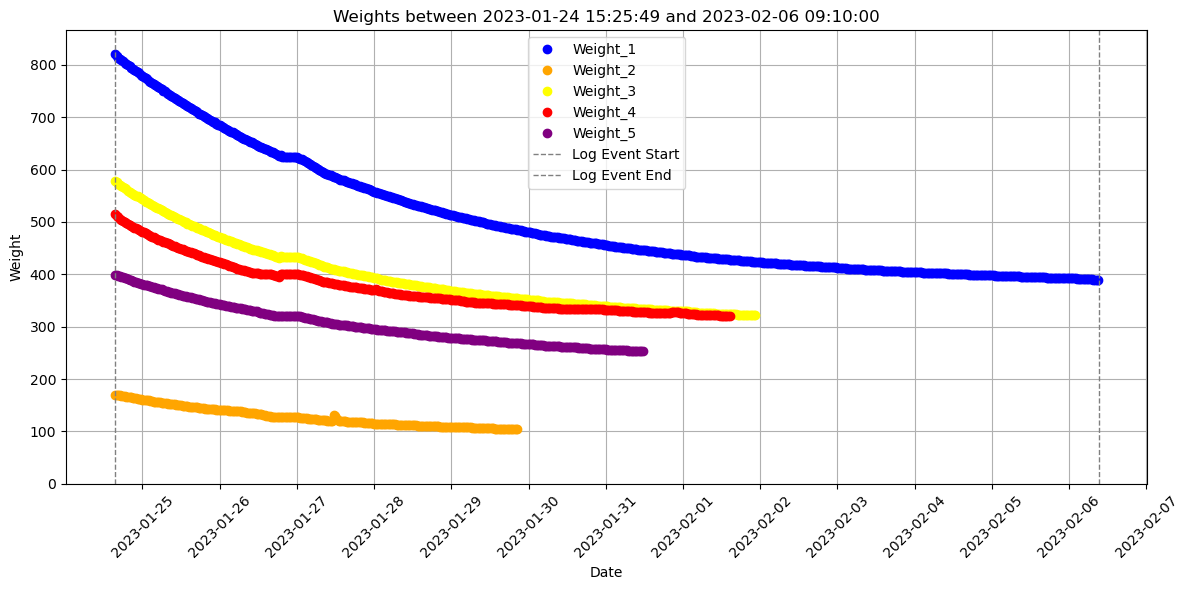

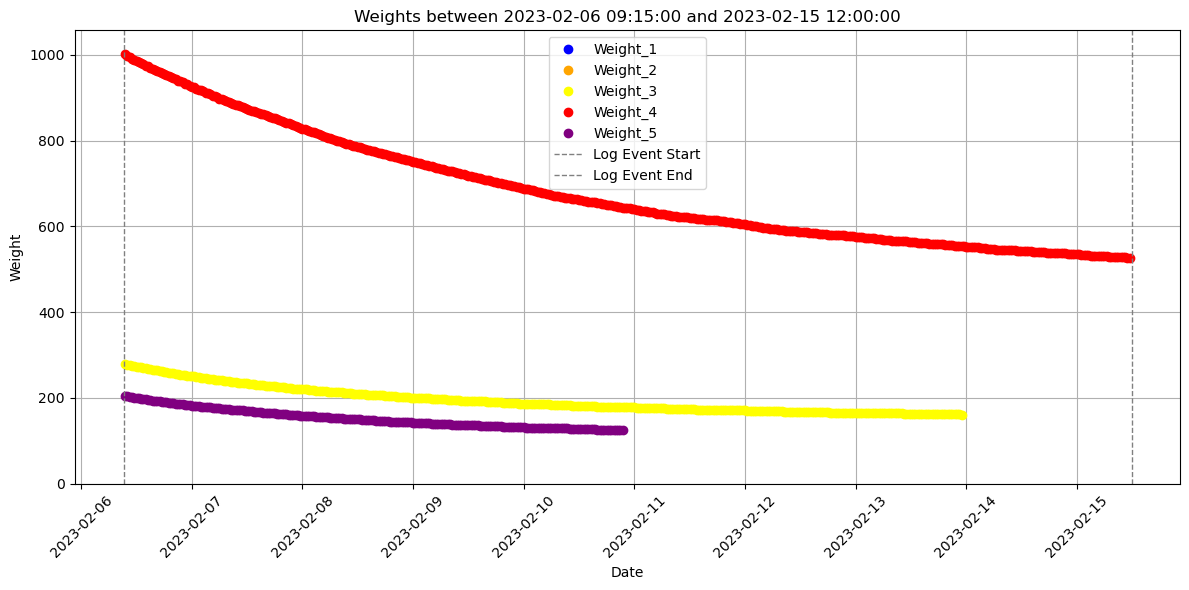

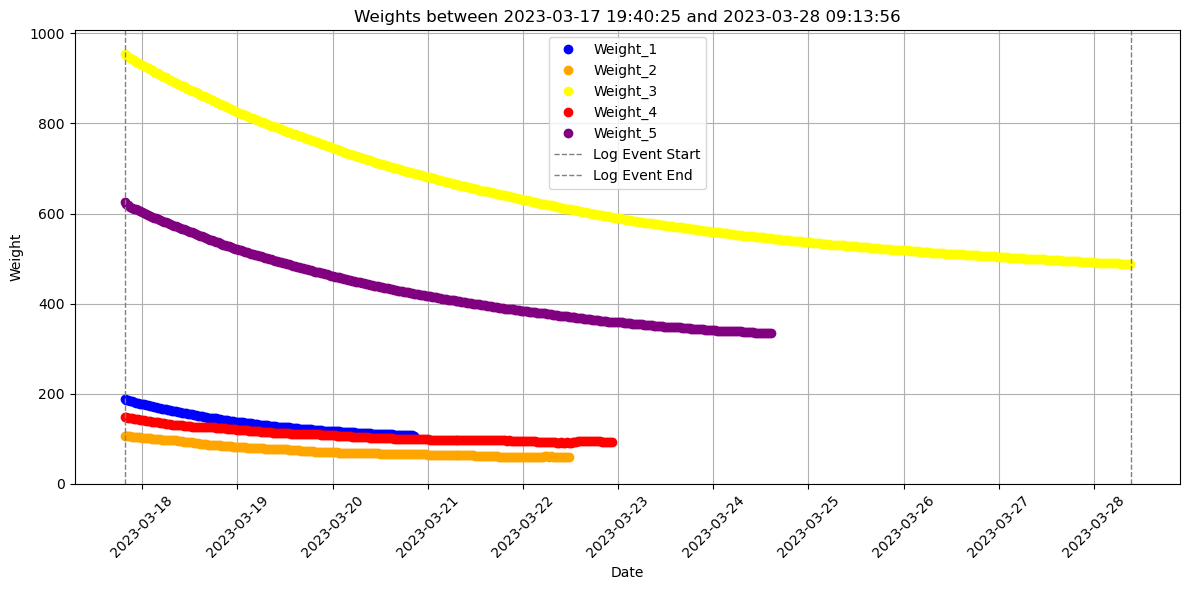

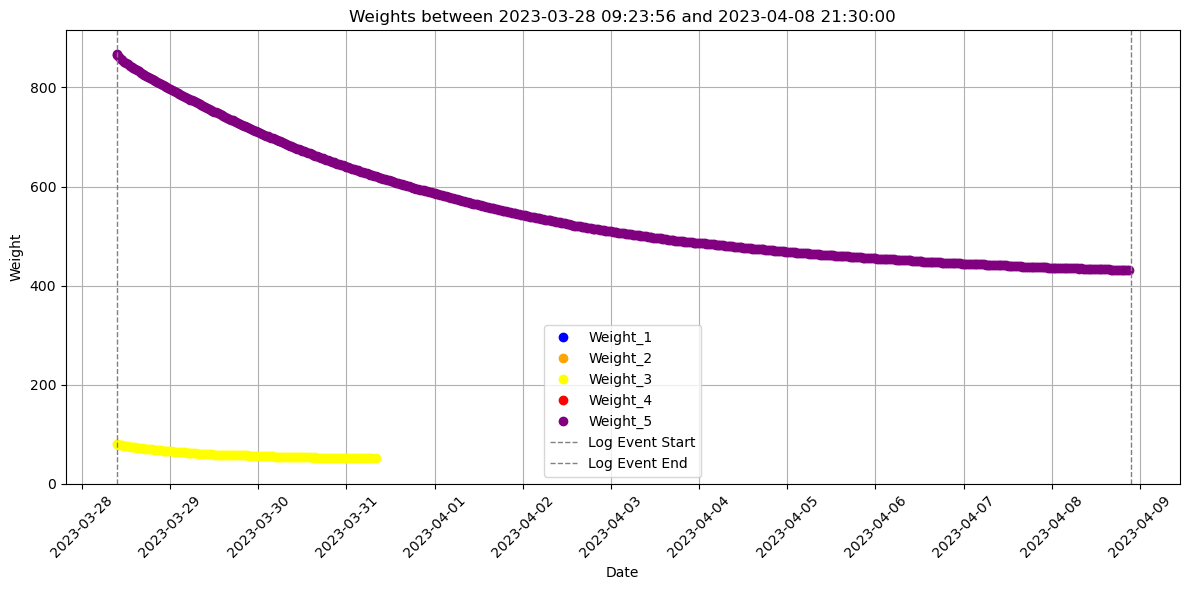

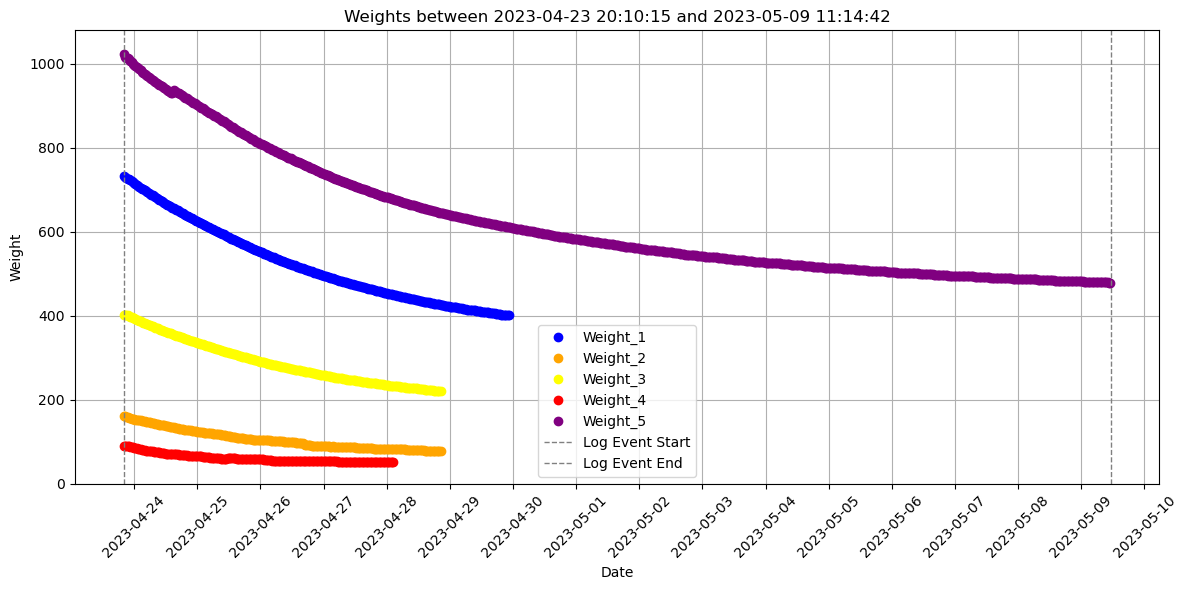

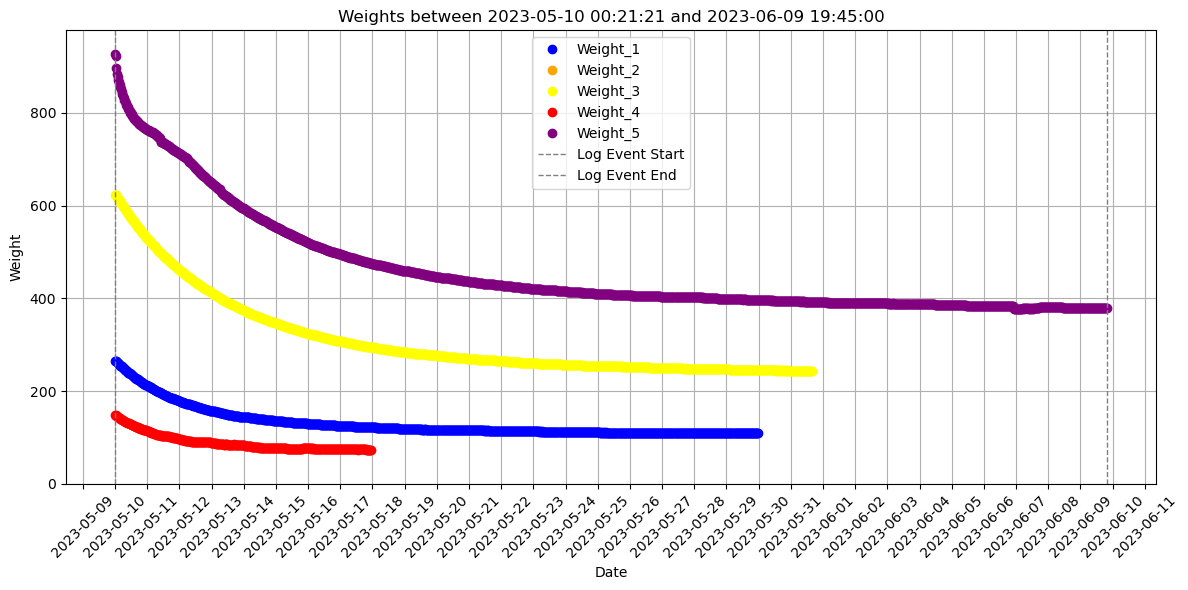

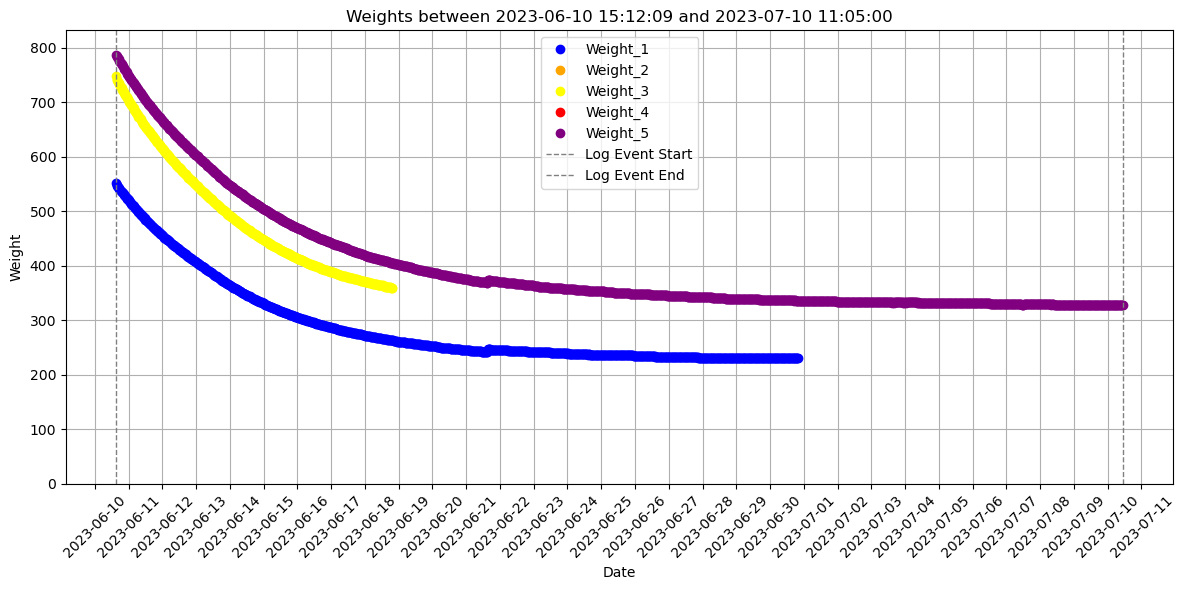

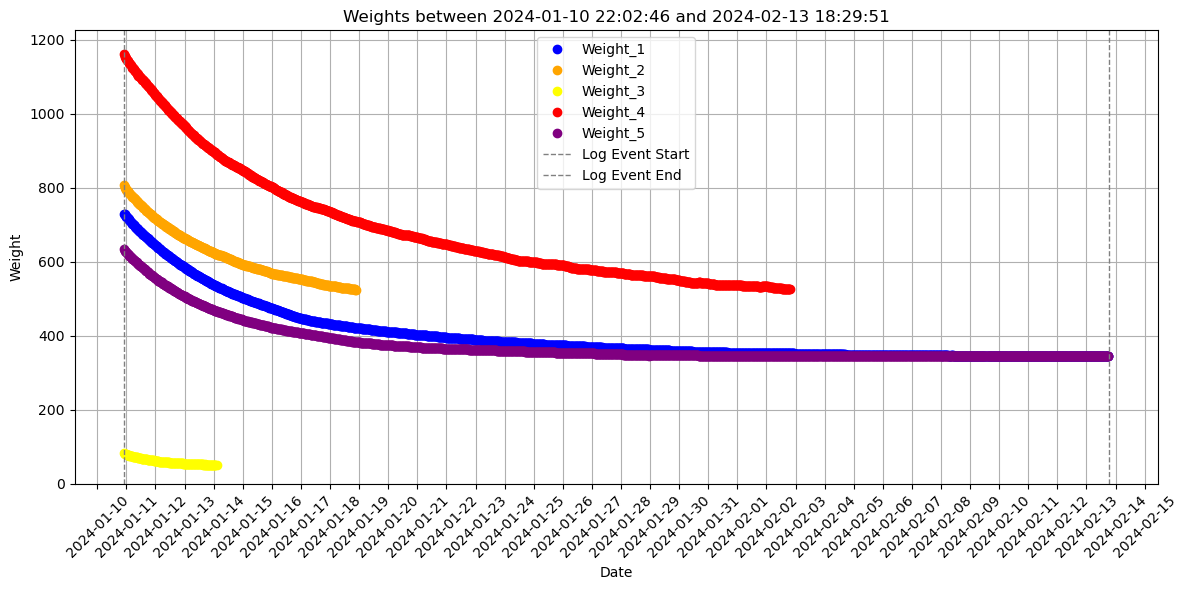

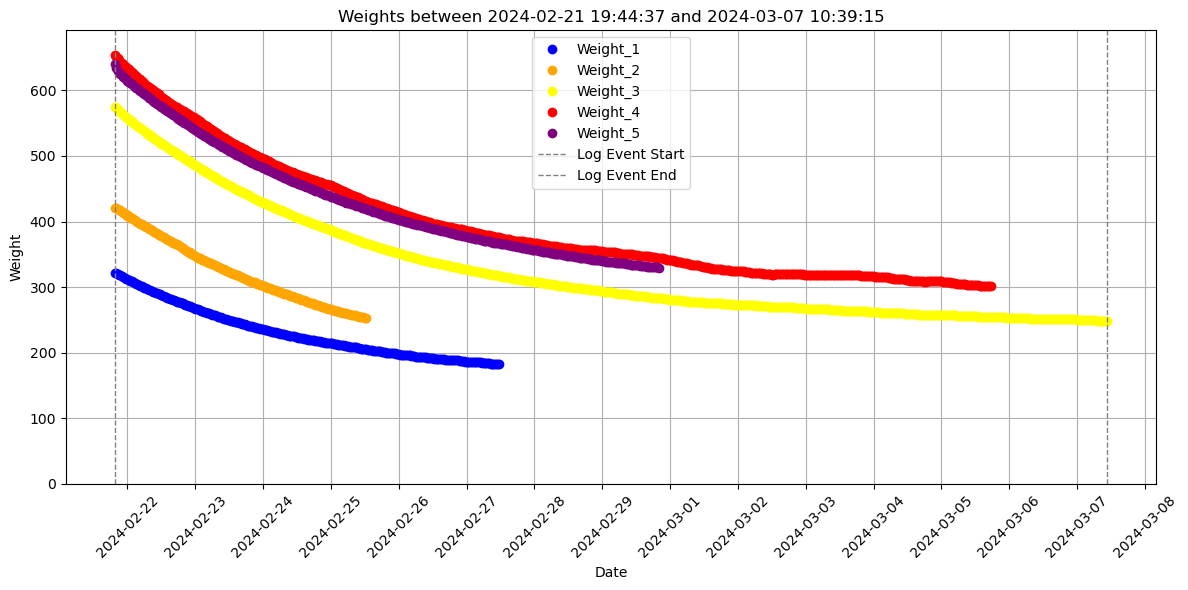

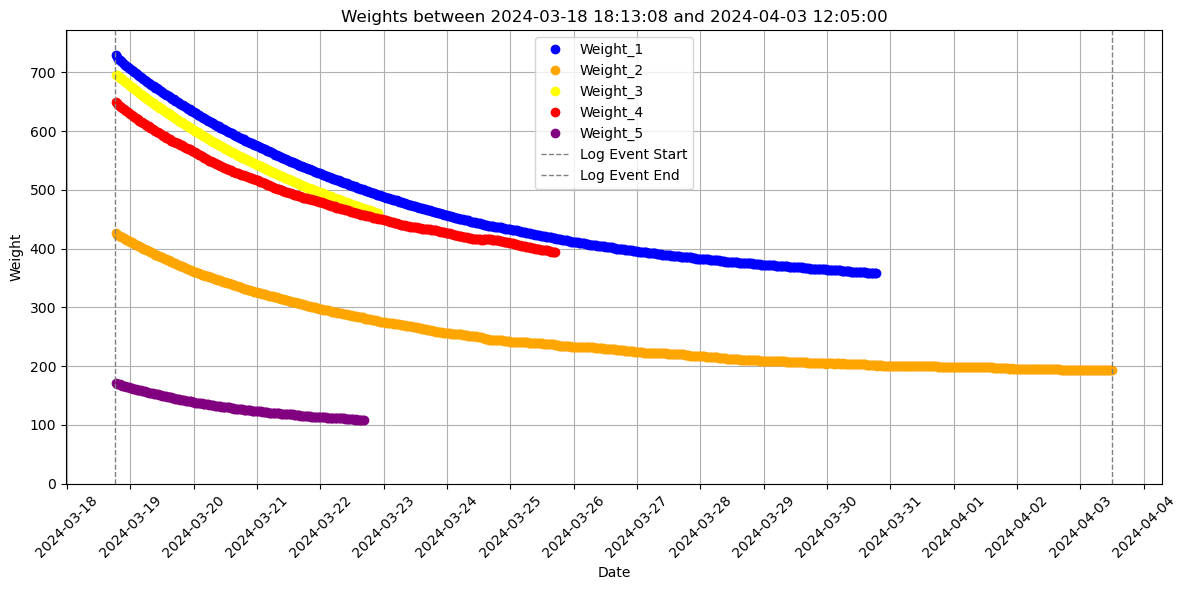

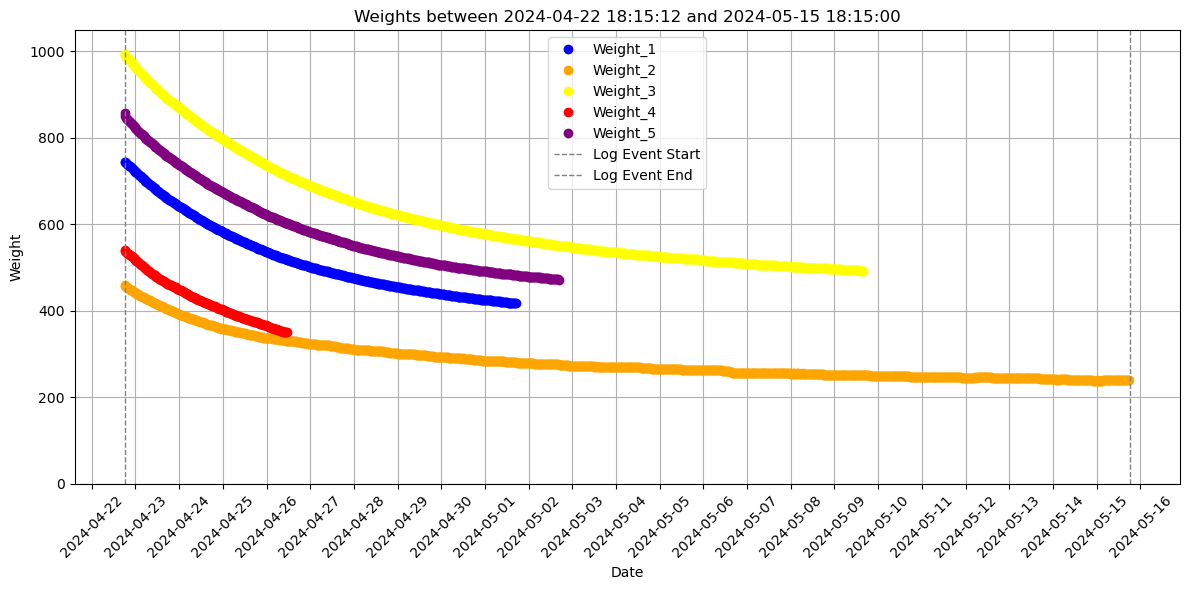

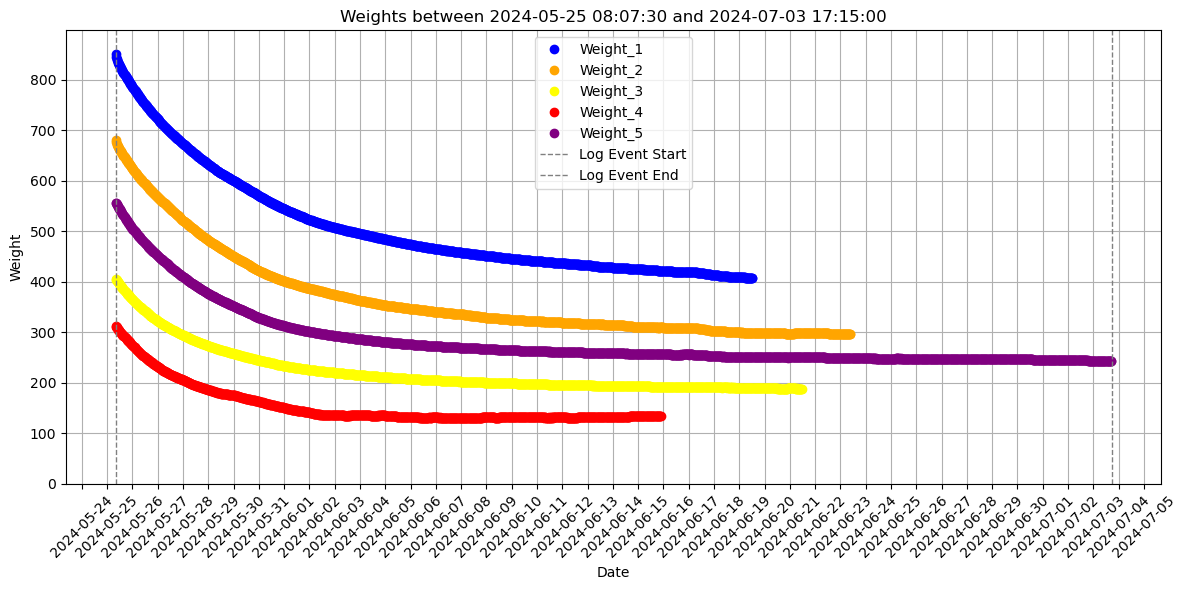

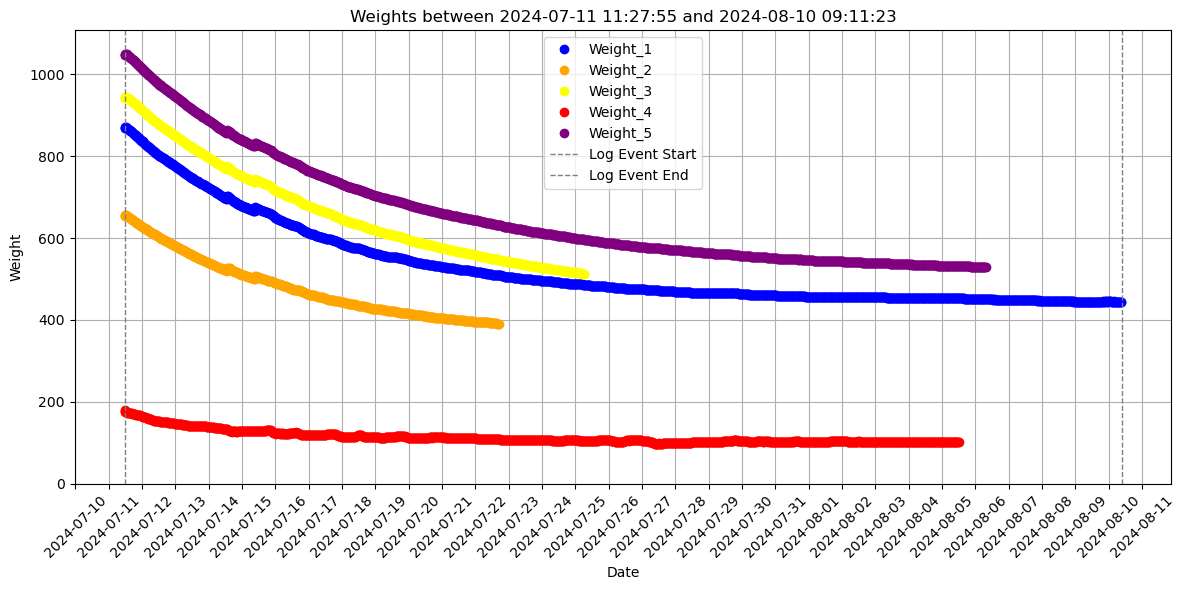

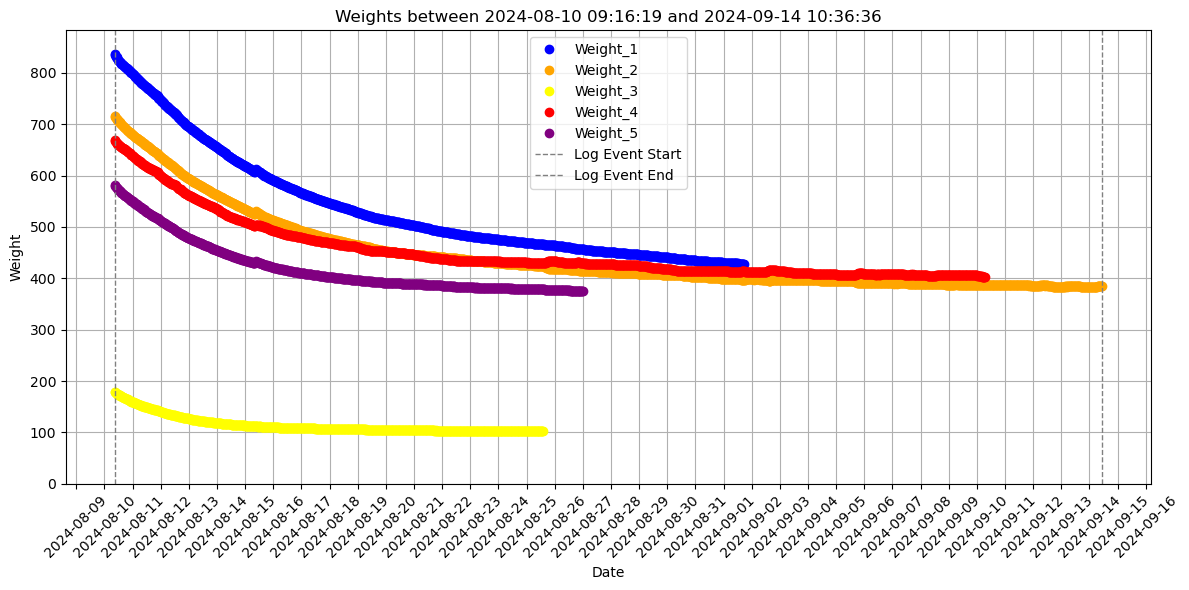

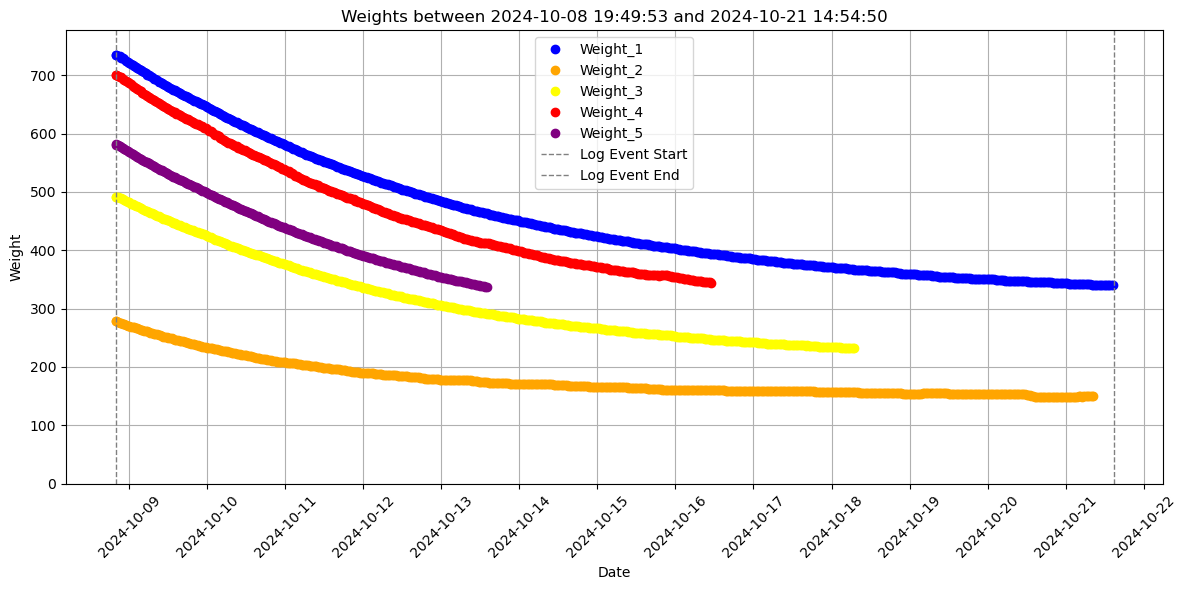

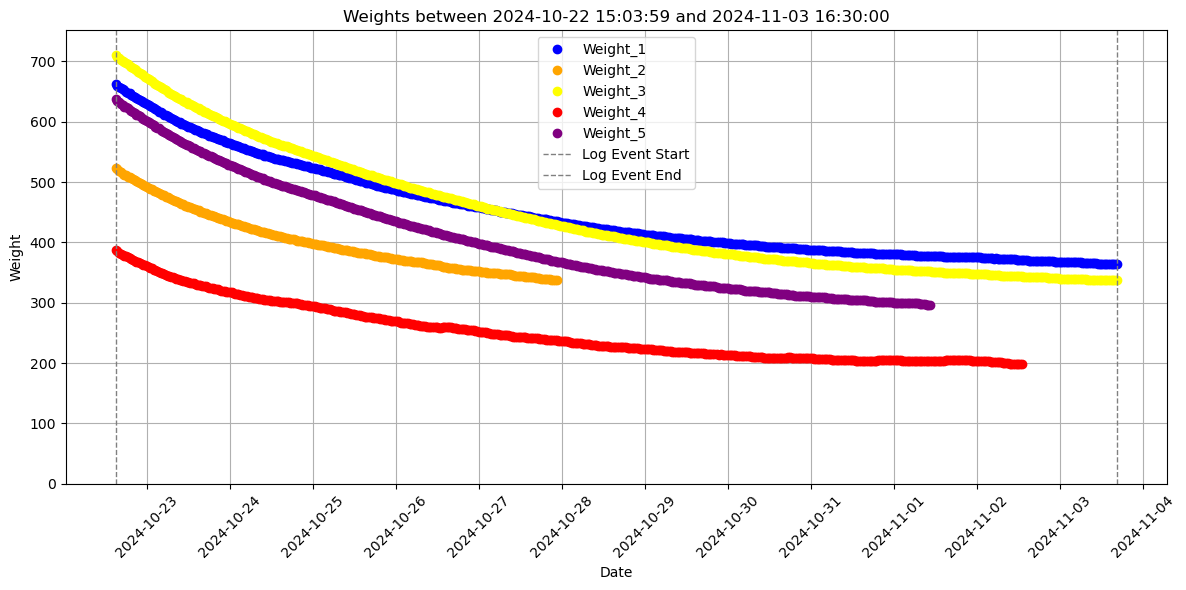

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust the width of the display
pd.set_option('display.max_colwidth', None)  # Show the full content of each cell


# Ensure 'Date' is a datetime column for proper plotting
combined_df['Date'] = pd.to_datetime(combined_df['Date']).dt.tz_localize(None)
log_event_start_df['Date'] = pd.to_datetime(log_event_start_df['Date']).dt.tz_localize(None)
log_event_stopped_df['Date'] = pd.to_datetime(log_event_stopped_df['Date']).dt.tz_localize(None)

# Filter the combined_df to include only rows where weights are greater than 50
filtered_df = combined_df[
    (combined_df['Weight_1'] > 50) | 
    (combined_df['Weight_2'] > 50) | 
    (combined_df['Weight_3'] > 50) | 
    (combined_df['Weight_4'] > 50) | 
    (combined_df['Weight_5'] > 50)
].copy()  # Create a copy of the filtered DataFrame

# Replace weights below 50 with -100 for visualization purposes
weights = ['Weight_1', 'Weight_2', 'Weight_3', 'Weight_4', 'Weight_5']
for weight in weights:
    filtered_df.loc[filtered_df[weight] <= 50, weight] = -100

# Sort log_event_start_df by 'Date'
log_event_start_df = log_event_start_df.sort_values(by='Date')
log_event_stopped_df = log_event_stopped_df.sort_values(by='Date')

#------------Filter date ranges
# Define the date range
start_date = pd.Timestamp('2021-04-20')
end_date = pd.Timestamp('2025-05-14')

# Filter log_event_start_df
log_event_start_fil_df = log_event_start_df[(log_event_start_df['Date'] >= start_date) & (log_event_start_df['Date'] <= end_date)]

# Filter log_event_stopped_df
log_event_stopped_fil_df = log_event_stopped_df[(log_event_stopped_df['Date'] >= start_date) & (log_event_stopped_df['Date'] <= end_date)]
#------------Filter date ranges

# Plot data between each pair of log events
for i in range(len(log_event_start_fil_df)):
    start_date = log_event_start_fil_df.iloc[i]['Date']
    end_date = log_event_stopped_fil_df.iloc[i]['Date']

    # Filter data between the current and next log event
    plot_df = filtered_df[(filtered_df['Date'] >= start_date) & (filtered_df['Date'] <= end_date)]

    #----------------------------Works for first set
    if (i==0):
        #display(plot_df)
        data = plot_df.copy()
        # Convert 'Date' column to datetime
        data['Date'] = pd.to_datetime(data['Date'])

        # Set 'Date' column as index
        data.set_index('Date', inplace=True)

        #display(data.head())
        data = data.iloc[1:]
        #display(data.head())

        # Generate a complete range of timestamps
        full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='30min')
        print("Start:",data.index.min())
        print("End:",data.index.max())

        # Reindex DataFrame to include all timestamps
        
        data = data.reindex(full_range)
        #display(data.head(10))
        # Ensure all columns are numeric for interpolation
        data = data.apply(pd.to_numeric, errors='coerce')

        # Interpolate missing values
        data.interpolate(method='linear', inplace=True)

        # Reset index to make 'Date' a column again if needed
        data.reset_index(inplace=True)
        data.rename(columns={'index': 'Date'}, inplace=True)

        plot_df=data.copy()
    #----------------------------Works for first set

    #-----------------To identify sudden jumps
    # Calculate the difference in Weight

    # for Weight in weights:
    if (i==3):
        plot_df.loc[:, 'Weight_1'] = np.nan
    if (i==4):
        plot_df = plot_df.reset_index(drop=True)

        # Find the index of the specific row
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2023-05-04 22:00:00')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 47

    if (i==7):
        plot_df = plot_df.reset_index(drop=True)
        
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-16 21:30:01')].index[0]
        plot_df.loc[row_index:, 'Weight_1'] += 155

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:00:01')].index[0]
        plot_df.loc[row_index:, 'Weight_1'] += 100

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:00:01')].index[0]
        plot_df.loc[row_index:row_index, 'Weight_1'] += 200
        

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-18 22:00:01')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 180
        
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:30:01')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 60
        
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-02-01 00:00:02')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 205

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:30:01')].index[0]
        plot_df.loc[row_index:row_index, 'Weight_5'] += 205

        #------Specific data range to modify
        start_date_1 = '2024-01-15 23:00:01'
        end_date_1 = '2024-01-16 21:30:01'

        row_index_s = plot_df[(plot_df['Date'] == start_date_1)].index[0]
        row_index_e = plot_df[(plot_df['Date'] == end_date_1)].index[0]

        # Filter DataFrame for the date range
        plot_df.loc[row_index_s:row_index_e, 'Weight_1'] = np.nan
        plot_df['Weight_1'] = plot_df['Weight_1'].interpolate()

        #------Specific data range to modify
        start_date_1 = '2024-01-16 21:30:01'
        end_date_1 = '2024-01-18 22:00:01'

        row_index_s = plot_df[(plot_df['Date'] == start_date_1)].index[0]
        row_index_e = plot_df[(plot_df['Date'] == end_date_1)].index[0]

        # Filter DataFrame for the date range
        plot_df.loc[row_index_s:row_index_e, 'Weight_5'] = np.nan
        # df['Weight_1'] = df['Weight_1'].replace(-100, pd.NA)  # Replace -100 with NaN for interpolation
        plot_df['Weight_5'] = plot_df['Weight_5'].interpolate()

        # sliced_df = plot_df.copy()
        # sliced_df['Weight_Diff'] = sliced_df["Weight_5"].diff()

        # # Define the threshold for sudden jump
        # threshold = 50  # Adjust this value based on your requirements

        # # Identify sudden jumps
        # sudden_jumps = sliced_df[abs(sliced_df['Weight_Diff']) > threshold]
        # up_jumps = sliced_df[(sliced_df['Weight_Diff']) > threshold]
        # down_jumps = sliced_df[(sliced_df['Weight_Diff']) < -threshold]

        # print("Rows with sudden jumps:")
        # display(sudden_jumps)

        # print("Rows with down jumps:")
        # display(down_jumps)

        # print("Rows with up jumps:")
        # display(up_jumps)

    #-----------------To identify sudden jumps
    if (i!=17):

        # Define a function to export weights
        def export_weights(df):
            for j in range(1, 6):  # Loop for weights from 1 to 5
                weight_col = f'Weight_{j}'
                filtered_df = df[df[weight_col] > 50].copy()  # Filter for weights greater than 50
                
                if not filtered_df.empty:  # Proceed only if there are values greater than 50
                    filtered_df['Jerky_ID'] = f"{i},{j}"  # Set the Jerky_ID column with a constant value for all rows
                    export_columns = ['Jerky_ID', 'Unix_time_Stamp', 'Date', 'Temp', 'Humidity', weight_col]
                    filtered_df = filtered_df[export_columns]  # Select required columns
                    
                    # Use raw string or double backslashes for file path
                    directory = r'pdata'  # Or use 'pdata\\'
                    filename = f'{directory}\\Jerky_{i}_{weight_col}.csv'
                    filtered_df.to_csv(filename, index=False)  # Export to CSV

        # Call the function to export weights
        export_weights(plot_df)

        plt.figure(figsize=(12, 6))
        plt.plot(plot_df['Date'], plot_df['Weight_1'], marker='o', linestyle='', color='b', label='Weight_1')
        plt.plot(plot_df['Date'], plot_df['Weight_2'], marker='o', linestyle='', color='orange', label='Weight_2')
        plt.plot(plot_df['Date'], plot_df['Weight_3'], marker='o', linestyle='', color='yellow', label='Weight_3')
        plt.plot(plot_df['Date'], plot_df['Weight_4'], marker='o', linestyle='', color='red', label='Weight_4')
        plt.plot(plot_df['Date'], plot_df['Weight_5'], marker='o', linestyle='', color='purple', label='Weight_5')
        
        plt.axvline(x=start_date, color='gray', linestyle='--', linewidth=1, label='Log Event Start')
        plt.axvline(x=end_date, color='gray', linestyle='--', linewidth=1, label='Log Event End')
        
        # Formatting the x-axis to show 1-day intervals
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        
        plt.xlabel('Date')
        plt.ylabel('Weight')
        plt.title(f'Weights between {start_date} and {end_date}')
        plt.legend()
        plt.grid(True)
        plt.ylim(bottom=0)  # Ensure y-axis starts at 0
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [22]:
# import pandas as pd
# import os
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.colors import Normalize, LinearSegmentedColormap

# # Path to the directory containing CSV files
# data_directory = 'pdata'

# # List to hold DataFrames
# dfs = []

# # Iterate over all CSV files in the directory
# for filename in os.listdir(data_directory):
#     if filename.endswith('.csv'):
#         filepath = os.path.join(data_directory, filename)
#         df = pd.read_csv(filepath)
#         dfs.append(df)

# # Print the shape of each DataFrame in the list
# # for i, df in enumerate(dfs):
# #     print(f"Shape of DataFrame {i+1}: {df.shape}")


In [23]:
# # Create a figure and axis for the plot
# #plt.figure(figsize=(20, 16))

# # Create a colormap for humidity
# norm = plt.Normalize(vmin=20, vmax=60)
# cmap = plt.get_cmap('coolwarm')

# # Create a ScalarMappable for the colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

# fig, ax = plt.subplots(figsize=(24, 4))  # Create the main plot

# # Iterate through each DataFrame and plot
# for df in dfs:
#     # Identify the Weight column (find column that starts with 'Weight_')
#     weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
#     if weight_cols:
#         weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
#         # Normalize the Weight column
#         df['Normalized_Weight'] = (df[weight_col] - df[weight_col].min()) / (df[weight_col].max() - df[weight_col].min())
        
#         # Normalize Humidity
#         df['Humidity'] = df['Humidity'].clip(lower=20, upper=60)  # Clip values to the range 20-60

#         # Map humidity to color
#         colors = cmap(norm(df['Humidity']))
        
#         # Scatter plot with gradient colors
#         plt.scatter(df.index, df['Normalized_Weight'], c=colors, s=2, alpha=0.7, label=weight_col)

# cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
# # Create colorbar
# #cbar = plt.colorbar(sm, orientation='vertical')
# print("No")
# cbar.set_label('Humidity')
# print("Yes")
# plt.xlabel('Index')
# plt.ylabel('Normalized Weight')
# plt.title('Normalized Weight Trends with Humidity Gradient')
# #plt.legend(title='Weight Column')
# plt.show()

In [24]:
# import pandas as pd
# import os
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.colors import LinearSegmentedColormap, Normalize

# # Path to the directory containing CSV files
# data_directory = 'pdata'

# # List to hold DataFrames
# dfs = []

# # Iterate over all CSV files in the directory
# for filename in os.listdir(data_directory):
#     if filename.endswith('.csv'):
#         filepath = os.path.join(data_directory, filename)
#         df = pd.read_csv(filepath)
#         dfs.append(df)

# # Collect all humidity values from each DataFrame
# all_humidity = []

# for df in dfs:
#     if 'Humidity' in df.columns:
#         all_humidity.extend(df['Humidity'])

# # Convert to a numpy array or pandas Series for easier min/max computation
# all_humidity = np.array(all_humidity)

# # Compute min and max
# min_humidity = np.min(all_humidity)
# max_humidity = np.max(all_humidity)

# print(f"Minimum Humidity: {min_humidity}")
# print(f"Maximum Humidity: {max_humidity}")

# # Define custom colormap
# colors = [(0, 'blue'), (0.5, 'green'), (1, 'red')]  # Blue at 20, Green at 40, Red at 60
# n_bins = [3]  # Discretizes the interpolation into bins
# cmap_name = 'custom_cmap'
# custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# # Define normalization for colormap
# norm = Normalize(vmin=min_humidity, vmax=max_humidity)

# # Create a ScalarMappable for the colorbar
# sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
# sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

# fig, ax = plt.subplots(figsize=(24, 4))  # Create the main plot

# #

# # Iterate through each DataFrame and plot
# for df in dfs:
#     # Identify the Weight column (find column that starts with 'Weight_')
#     weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
#     if weight_cols:
#         weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
#         # Normalize the Weight column
#         #df['Normalized_Weight'] = (df[weight_col] - df[weight_col].min()) / (df[weight_col].max() - df[weight_col].min())
#         df['Normalized_Weight'] =  ( df[weight_col]/df[weight_col].max())
        
#         # Normalize Humidity
#         df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range 20-60

#         # Map humidity to color
#         colors = custom_cmap(norm(df['Humidity']))
        
#         # Scatter plot with gradient colors
#         plt.scatter(df.index, df['Normalized_Weight'], c=colors, s=2, alpha=0.2, label=weight_col)

# # Add colorbar
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
# cbar.set_label('Humidity')

# plt.xlabel('Index')
# plt.ylabel('Normalized Weight')
# plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# # Optionally add a legend
# # plt.legend(title='Weight Column')

# plt.show()


In [25]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches  # Import patches module

# Path to the directory containing CSV files
data_directory = 'pdata'

# List to hold DataFrames
dfs = []

# Iterate over all CSV files in the directory
for filename in os.listdir(data_directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(data_directory, filename)
        df = pd.read_csv(filepath)
        # Calculate the new column
        df['Temp_Humidity_Ratio'] =  df['Humidity']/df['Temp'] 
        # Identify the Weight column
        weight_cols = [col for col in df.columns if col.startswith('Weight_')]
        if weight_cols:
            weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
            
            # Calculate the difference in weight
            df['Weight_Difference'] = df[weight_col].diff()
        dfs.append(df)

# Collect all humidity values from each DataFrame
all_humidity = []
all_temp = []
all_temp_humid_ratio = []
all_weight = []

for df in dfs:
    if 'Humidity' in df.columns:
        all_humidity.extend(df['Humidity'])
    if 'Temp' in df.columns:
        all_temp.extend(df['Temp'])    
    if 'Temp_Humidity_Ratio' in df.columns:
        all_temp_humid_ratio.extend(df['Temp_Humidity_Ratio'])
        # Identify the Weight column
    weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    if weight_cols:
            weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
            all_weight.extend(df[weight_col])  

# Convert to a numpy array or pandas Series for easier min/max computation
all_humidity = np.array(all_humidity)
all_temp = np.array(all_temp)
all_temp_humid_ratio = np.array(all_temp_humid_ratio)
all_weight = np.array(all_weight)

# Compute min and max
min_humidity = np.min(all_humidity)
max_humidity = np.max(all_humidity)
min_temp = np.min(all_temp)
max_temp = np.max(all_temp)
min_temp_humid_ratio = np.min(all_temp_humid_ratio)
max_temp_humid_ratio = np.max(all_temp_humid_ratio)
min_weight = np.min(all_weight)
max_weight = np.max(all_weight)

print(f"Minimum Humidity: {min_humidity}")
print(f"Maximum Humidity: {max_humidity}")
print(f"Minimum Temperature: {min_temp}")
print(f"Maximum Temperature: {max_temp}")
print(f"Minimum Temperature/Humidity Ratio: {min_temp_humid_ratio:.3f}")
print(f"Maximum Temperature/Humidity Ratio: {max_temp_humid_ratio:.3f}")
print(f"Minimum Weight: {min_weight}")
print(f"Maximum Weight: {max_weight}")

# Initialize variable to store the maximum length
max_length = 0

# Iterate over each DataFrame to find the maximum index length
for df in dfs:
    index_length = len(df.index)
    if index_length > max_length:
        max_length = index_length

print(f"Longest index length: {max_length}")

# Define custom colormap
#colors = [(0, 'blue'), (0.5, 'green'), (1, 'red')]  # Blue at 20, Green at 40, Red at 60
colors = [(0, 'blue'), (0.2, 'green'),(0.4, 'yellow'),(0.8, 'orange'), (1, 'red')]  # Blue at 20, Green at 40, Red at 60
n_bins = [3]  # Discretizes the interpolation into bins
cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Define normalization for colormap
norm = Normalize(vmin=min_humidity, vmax=max_humidity)



Minimum Humidity: 17.9
Maximum Humidity: 56.2
Minimum Temperature: 15.9
Maximum Temperature: 28.6
Minimum Temperature/Humidity Ratio: 1.072
Maximum Temperature/Humidity Ratio: 2.559
Minimum Weight: 51.0
Maximum Weight: 1162.0
Longest index length: 1891


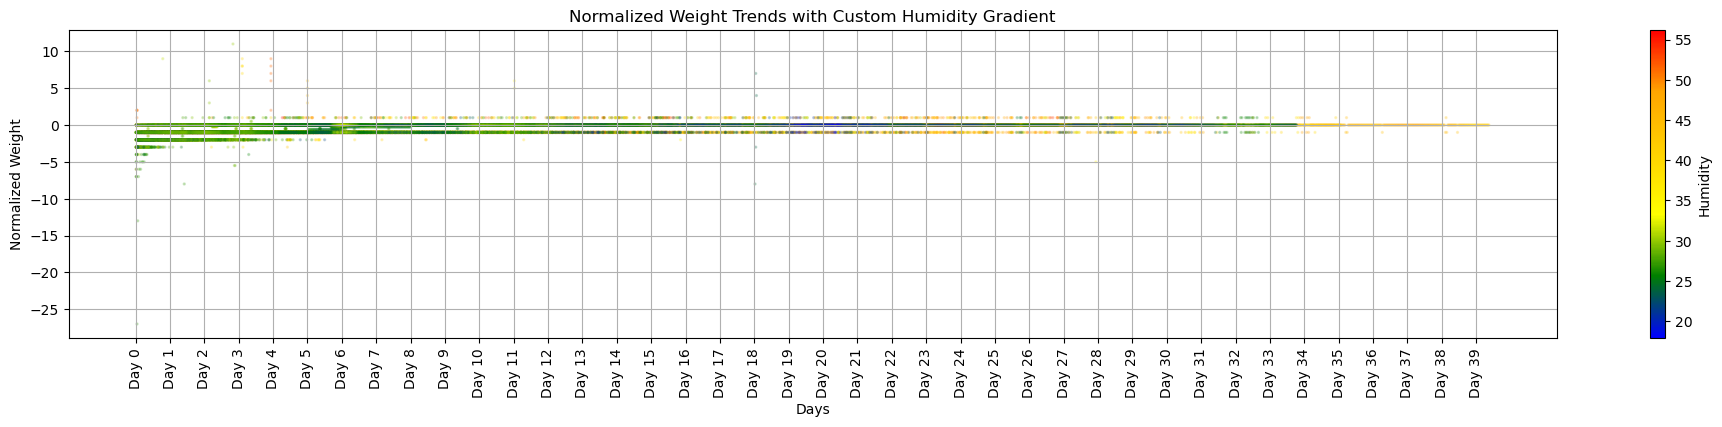

In [26]:
# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

fig, ax = plt.subplots(figsize=(24, 4))  # Create the main plot

# Iterate through each DataFrame and plot
for df in dfs:
    # Identify the Weight column (find column that starts with 'Weight_')
    # Normalize Humidity
    df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range

    # Map humidity to color
    colors = custom_cmap(norm(df['Humidity']))
    
    # Scatter plot with gradient colors
    plt.scatter(df.index, df['Weight_Difference'], c=colors, s=2, alpha=0.2, label="Weight_Difference")

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Humidity')

# Set x-axis ticks
tick_locator = MaxNLocator(integer=True, prune='lower', nbins=max_length//48)
ax.xaxis.set_major_locator(tick_locator)
ax.set_xticks(np.arange(0, max_length, 48))
ax.set_xticklabels([f'Day {i//48 + 0}' for i in range(0, max_length, 48)], rotation=90)

ax.grid(True) 

plt.xlabel('Days')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# Optionally add a legend
# plt.legend(title='Weight Column')

plt.show()

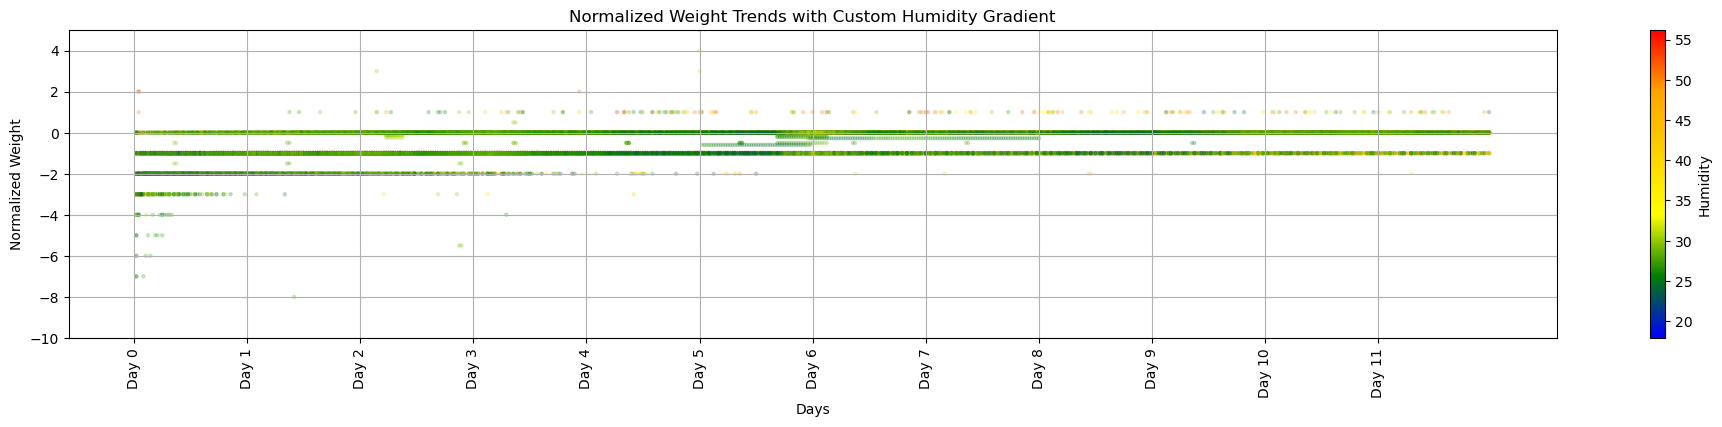

In [27]:
# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

fig, ax = plt.subplots(figsize=(24, 4))  # Create the main plot

# Define the range to plot (first 4 days)
start_index = 0
end_index = 12 * 48  # 4 days worth of data

# Iterate through each DataFrame and plot
for df in dfs:
    # Identify the Weight column (find column that starts with 'Weight_')
    # Normalize Humidity
    df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range

    # Filter the DataFrame to include only the first 4 days
    df_filtered = df.iloc[start_index:end_index]
    
    # Map humidity to color
    colors = custom_cmap(norm(df_filtered['Humidity']))
    
    # Scatter plot with gradient colors
    plt.scatter(df_filtered.index, df_filtered['Weight_Difference'], c=colors, s=5, alpha=0.2, label="Weight_Difference")

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Humidity')

# Set x-axis ticks
tick_locator = MaxNLocator(integer=True, prune='lower', nbins=end_index//48)
ax.xaxis.set_major_locator(tick_locator)
ax.set_xticks(np.arange(0, end_index, 48))
ax.set_xticklabels([f'Day {i//48 + 0}' for i in range(0, end_index, 48)], rotation=90)

# Set y-axis limits
ax.set_ylim(-10, 5)

ax.grid(True) 

plt.xlabel('Days')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# Optionally add a legend
# plt.legend(title='Weight Column')

plt.show()

In [28]:
# # Create a ScalarMappable for the colorbar
# sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
# sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

# fig, ax = plt.subplots(figsize=(24, 4))  # Create the main plot

# # Iterate through each DataFrame and plot
# for df in dfs:
#     # Identify the Weight column (find column that starts with 'Weight_')
#     weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
#     if weight_cols:
#         weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
#         # Normalize the Weight column
#         df['Normalized_Weight'] =  ( df[weight_col]/df[weight_col].max())
        
#         # Normalize Humidity
#         df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range

#         # Map humidity to color
#         colors = custom_cmap(norm(df['Humidity']))
        
#         # Scatter plot with gradient colors
#         plt.scatter(df.index, df['Normalized_Weight'], c=colors, s=2, alpha=0.2, label=weight_col)

# # Add colorbar
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
# cbar.set_label('Humidity')

# # Set x-axis ticks
# tick_locator = MaxNLocator(integer=True, prune='lower', nbins=max_length//48)
# ax.xaxis.set_major_locator(tick_locator)
# ax.set_xticks(np.arange(0, max_length, 48))
# ax.set_xticklabels([f'Day {i//48 + 0}' for i in range(0, max_length, 48)], rotation=90)

# ax.grid(True) 

# plt.xlabel('Days')
# plt.ylabel('Normalized Weight')
# plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# # Optionally add a legend
# # plt.legend(title='Weight Column')

# plt.show()

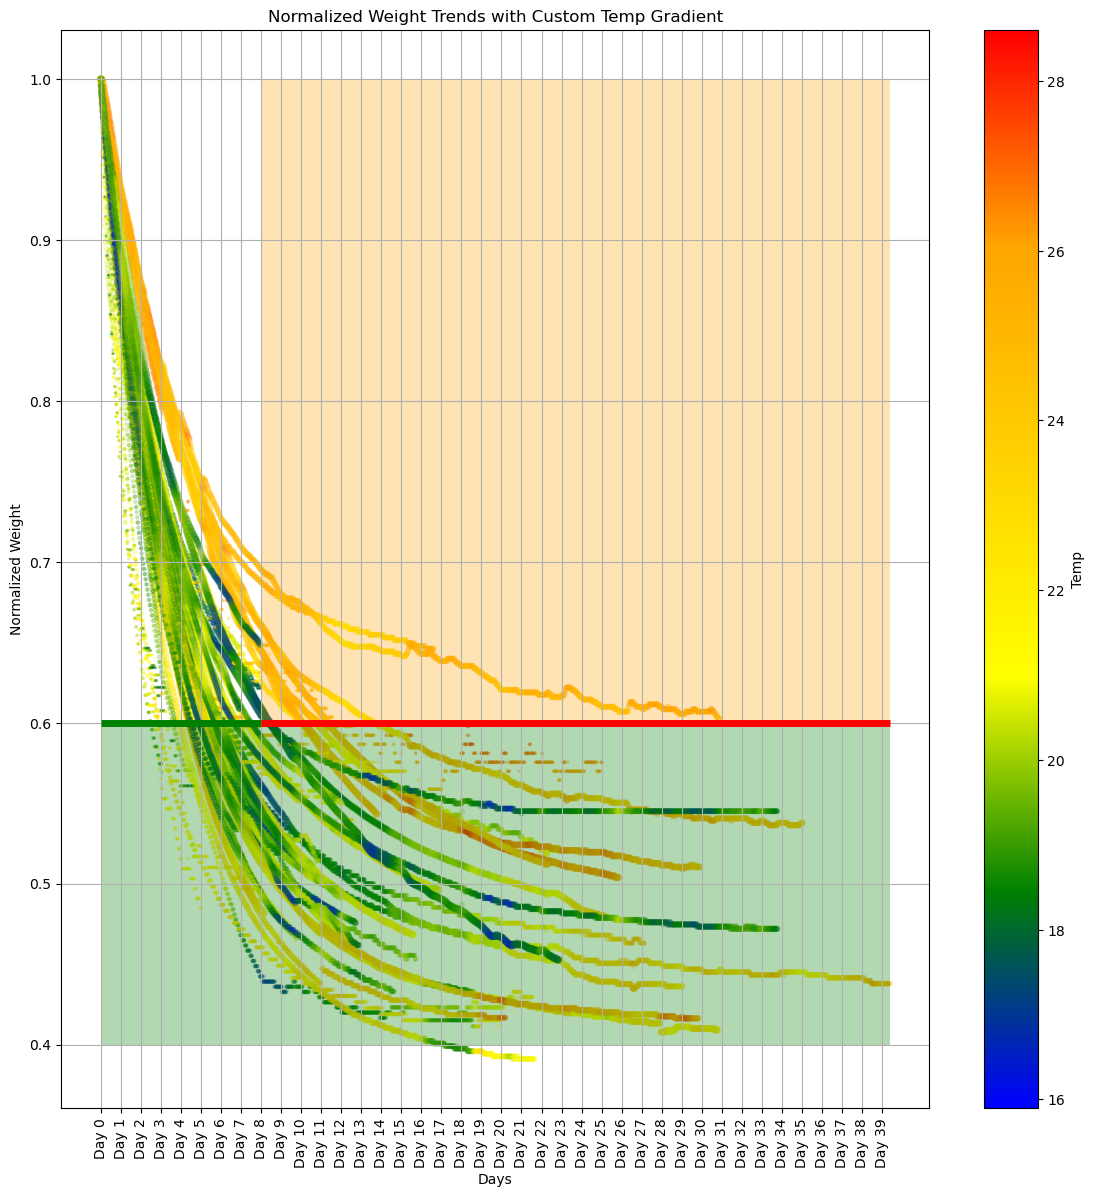

In [29]:
# Define normalization for colormap
norm = Normalize(vmin=min_temp, vmax=max_temp)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

fig, ax = plt.subplots(figsize=(14, 14))  # Create the main plot

# Iterate through each DataFrame and plot
for df in dfs:
    # Identify the Weight column (find column that starts with 'Weight_')
    weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
    if weight_cols:
        weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
        # Normalize the Weight column
        df['Normalized_Weight'] =  ( df[weight_col]/df[weight_col].max())
        
        # Normalize Humidity
        df['Temp'] = df['Temp'].clip(lower=min_temp, upper=max_temp)  # Clip values to the range

        # Map humidity to color
        colors = custom_cmap(norm(df['Temp']))
        
        #Dot size, depends on how large the piece is
        dot_size = (df[weight_col].max()/max_weight) *20

        # Scatter plot with gradient colors
        plt.scatter(df.index, df['Normalized_Weight'], c=colors, s=dot_size, alpha=0.2, label=weight_col)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Temp')

# Add transparent green box
green_rect = patches.Rectangle(
    (0, 0.4),  # Bottom-left corner (x, y)
    max_length,  # Width (number of ticks for 5 days)
    0.2,     # Height
    linewidth=1, edgecolor='none', facecolor='green', alpha=0.3)  # Adjust transparency with alpha
ax.add_patch(green_rect)

# Add transparent orange box
orange_limit_start = 48*8
orange_rect = patches.Rectangle(
    (orange_limit_start, 0.6),  # Bottom-left corner (x, y)
    max_length-orange_limit_start,  # Width (number of ticks for 5 days)
    0.4,     # Height
    linewidth=1, edgecolor='none', facecolor='orange', alpha=0.3)  # Adjust transparency with alpha
ax.add_patch(orange_rect)

# Adding the green horizontal line
ax.hlines(xmin=0*48,xmax=8*48,y=0.6, color='green', linestyle='-', linewidth=5, label='Threshold Line')
ax.hlines(xmin=8*48,xmax=max_length,y=0.6, color='red', linestyle='-', linewidth=5, label='Threshold Line')

# Set x-axis ticks
tick_locator = MaxNLocator(integer=True, prune='lower', nbins=max_length//48)
ax.xaxis.set_major_locator(tick_locator)
ax.set_xticks(np.arange(0, max_length, 48))
ax.set_xticklabels([f'Day {i//48 + 0}' for i in range(0, max_length, 48)], rotation=90)

ax.grid(True) 

plt.xlabel('Days')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weight Trends with Custom Temp Gradient')

# Optionally add a legend
# plt.legend(title='Weight Column')

plt.show()

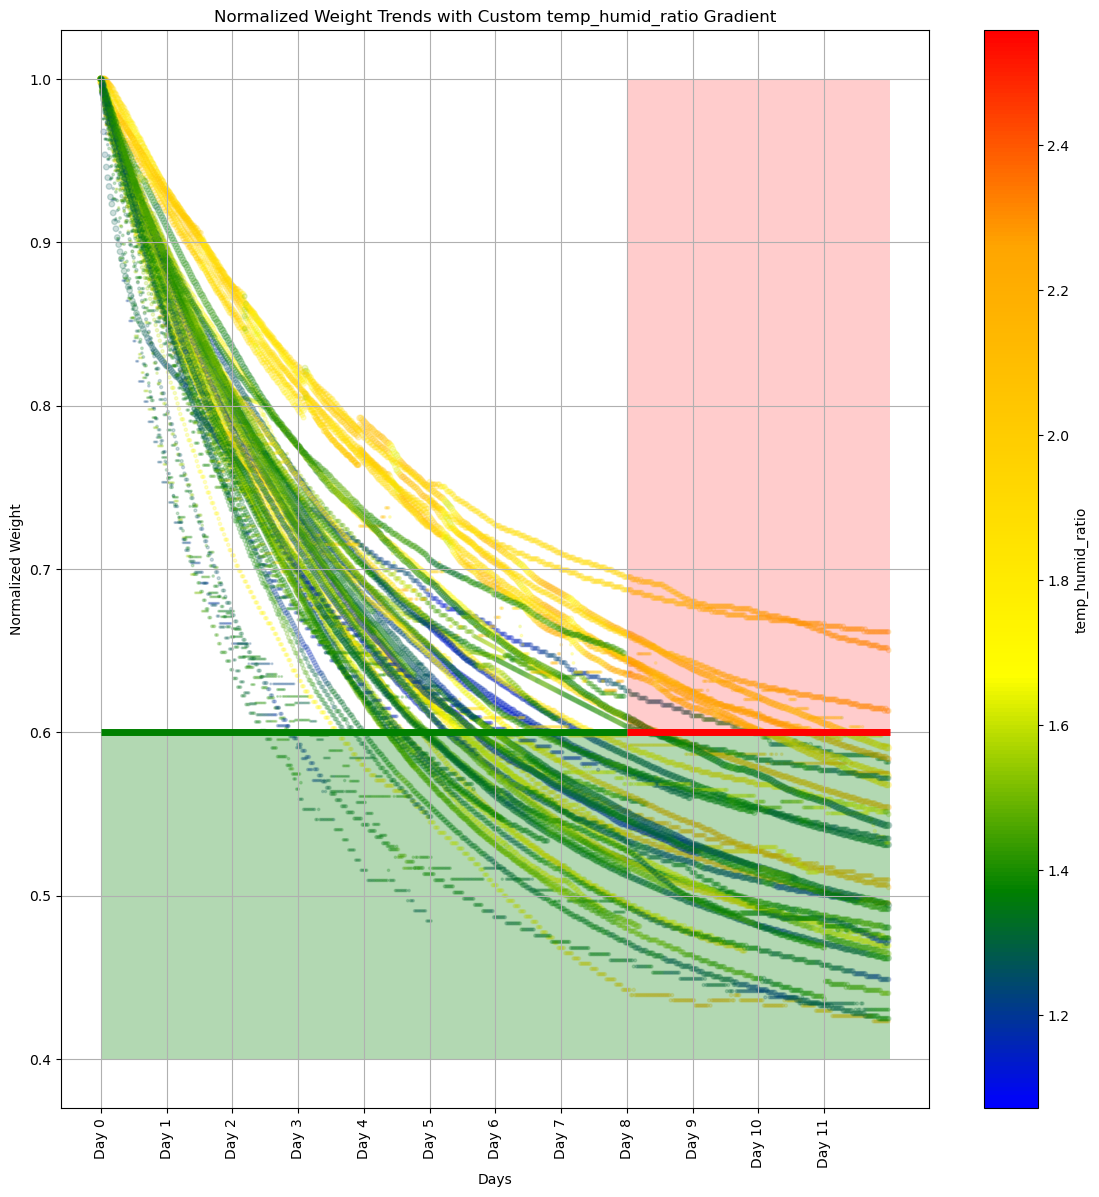

In [30]:
# Define normalization for colormap
norm = Normalize(vmin=min_temp_humid_ratio, vmax=max_temp_humid_ratio)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

fig, ax = plt.subplots(figsize=(14, 14))  # Create the main plot

# Define the range to plot (first 4 days)
start_index = 0
end_index = 12 * 48 #max_lenght # 4 days worth of data

# Iterate through each DataFrame and plot
for df in dfs:
    # Identify the Weight column (find column that starts with 'Weight_')
    weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
    if weight_cols:
        weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
        # Normalize the Weight column
        df['Normalized_Weight'] =  ( df[weight_col]/df[weight_col].max())
        
        # Normalize Humidity
        df['Temp_Humidity_Ratio'] = df['Temp_Humidity_Ratio'].clip(lower=min_temp_humid_ratio, upper=max_temp_humid_ratio)  # Clip values to the range

        df_filtered = df.iloc[start_index:end_index]

        # Map humidity to color
        colors = custom_cmap(norm(df_filtered['Temp_Humidity_Ratio']))
        
        #Dot size, depends on how large the piece is
        dot_size = (df[weight_col].max()/max_weight) *20

        # Scatter plot with gradient colors
        plt.scatter(df_filtered.index, df_filtered['Normalized_Weight'], c=colors, s=dot_size, alpha=0.2, label=weight_col)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('temp_humid_ratio')

# Add transparent green box
green_rect = patches.Rectangle(
    (0, 0.4),  # Bottom-left corner (x, y)
    end_index,  # Width (number of ticks for 5 days)
    0.2,     # Height
    linewidth=1, edgecolor='none', facecolor='green', alpha=0.3)  # Adjust transparency with alpha
ax.add_patch(green_rect)

# Add transparent orange box
orange_limit_start = 48*8
orange_rect = patches.Rectangle(
    (orange_limit_start, 0.6),  # Bottom-left corner (x, y)
    end_index-orange_limit_start,  # Width (number of ticks for 5 days)
    0.4,     # Height
    linewidth=1, edgecolor='none', facecolor='red', alpha=0.2)  # Adjust transparency with alpha
ax.add_patch(orange_rect)

# Adding the green horizontal line
ax.hlines(xmin=0*48,xmax=8*48,y=0.6, color='green', linestyle='-', linewidth=5, label='Threshold Line')
ax.hlines(xmin=8*48,xmax=end_index,y=0.6, color='red', linestyle='-', linewidth=5, label='Threshold Line')

# Set x-axis ticks
tick_locator = MaxNLocator(integer=True, prune='lower', nbins=end_index//48)
ax.xaxis.set_major_locator(tick_locator)
ax.set_xticks(np.arange(0, end_index, 48))
ax.set_xticklabels([f'Day {i//48 + 0}' for i in range(0, end_index, 48)], rotation=90)

ax.grid(True) 

plt.xlabel('Days')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weight Trends with Custom temp_humid_ratio Gradient')

# Optionally add a legend
# plt.legend(title='Weight Column')

plt.show()

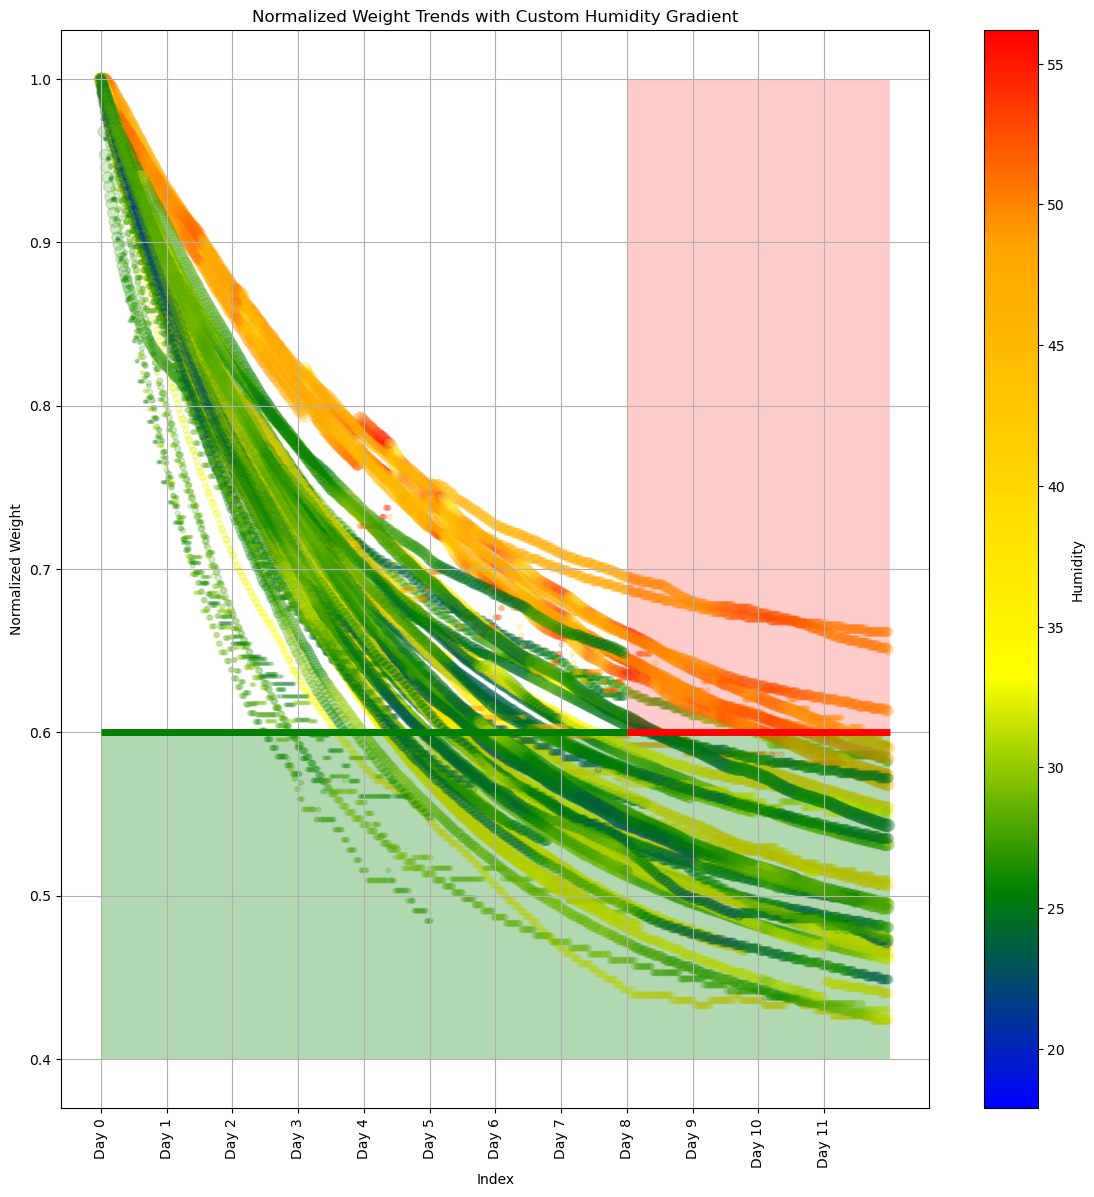

In [31]:
# Define normalization for colormap
norm = Normalize(vmin=min_humidity, vmax=max_humidity)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

fig, ax = plt.subplots(figsize=(14, 14))  # Create the main plot

# Define the range to plot (first 4 days)
start_index = 0
end_index = 12 * 48  # 4 days worth of data

# Iterate through each DataFrame and plot
for df in dfs:
    # Identify the Weight column (find column that starts with 'Weight_')
    weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
    if weight_cols:
        weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
        # Normalize the Weight column
        df['Normalized_Weight'] = (df[weight_col] / df[weight_col].max())
        
        # Normalize Humidity
        df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range min-max

        # Filter the DataFrame to include only the first 4 days
        df_filtered = df.iloc[start_index:end_index]

        # Map humidity to color
        colors = custom_cmap(norm(df_filtered['Humidity']))

        #Dot size, depends on how large the piece is
        dot_size = (df[weight_col].max()/max_weight) *80
        
        # Scatter plot with gradient colors
        plt.scatter(df_filtered.index, df_filtered['Normalized_Weight'], c=colors, s=dot_size, alpha=0.2, label=weight_col)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Humidity')

# Add transparent green box
green_rect = patches.Rectangle(
    (0, 0.4),  # Bottom-left corner (x, y)
    end_index,  # Width (number of ticks for 5 days)
    0.2,     # Height
    linewidth=1, edgecolor='none', facecolor='green', alpha=0.3)  # Adjust transparency with alpha
ax.add_patch(green_rect)

# Add transparent orange box
orange_limit_start = 48*8
orange_rect = patches.Rectangle(
    (orange_limit_start, 0.6),  # Bottom-left corner (x, y)
    end_index-orange_limit_start,  # Width (number of ticks for 5 days)
    0.4,     # Height
    linewidth=1, edgecolor='none', facecolor='red', alpha=0.2)  # Adjust transparency with alpha
ax.add_patch(orange_rect)

# Adding the green horizontal line
ax.hlines(xmin=0*48,xmax=8*48,y=0.6, color='green', linestyle='-', linewidth=5, label='Threshold Line')
ax.hlines(xmin=8*48,xmax=end_index,y=0.6, color='red', linestyle='-', linewidth=5, label='Threshold Line')



# Set x-ticks at intervals of 48
tick_positions = range(start_index, end_index, 48)
tick_labels = [f'Day {i // 48 + 0}' for i in tick_positions]

# Apply the ticks and labels to the x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=90)  # Rotate labels if needed

# Add grid
ax.grid(True)  # Adds grid lines

# Set y-axis to logarithmic scale
#ax.set_yscale('log')

plt.xlabel('Index')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# Optionally add a legend
# plt.legend(title='Weight Column')

plt.show()

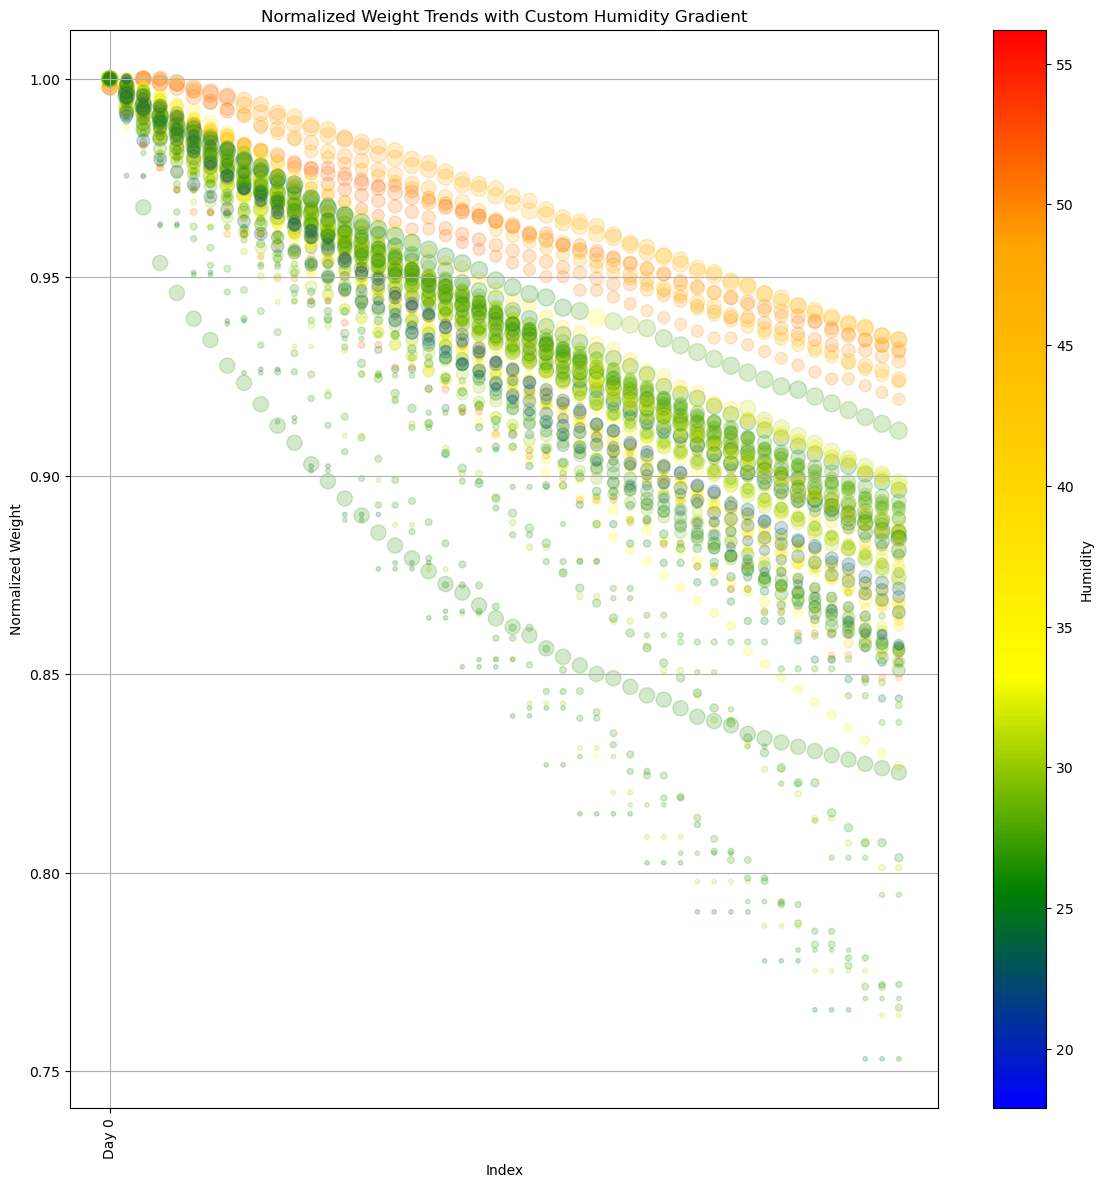

In [32]:
# Define normalization for colormap
norm = Normalize(vmin=min_humidity, vmax=max_humidity)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

fig, ax = plt.subplots(figsize=(14, 14))  # Create the main plot

# Define the range to plot (first 4 days)
start_index = 0
end_index = 1 * 48  # 4 days worth of data

# Iterate through each DataFrame and plot
for df in dfs:
    # Identify the Weight column (find column that starts with 'Weight_')
    weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
    if weight_cols:
        weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
        # Normalize the Weight column
        df['Normalized_Weight'] = (df[weight_col] / df[weight_col].max())
        
        # Normalize Humidity
        df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range min-max

        # Filter the DataFrame to include only the first 4 days
        df_filtered = df.iloc[start_index:end_index]

        # Map humidity to color
        colors = custom_cmap(norm(df_filtered['Humidity']))

        #Dot size, depends on how large the piece is
        dot_size = (df[weight_col].max()/max_weight) *150
        
        # Scatter plot with gradient colors
        plt.scatter(df_filtered.index, df_filtered['Normalized_Weight'], c=colors, s=dot_size, alpha=0.2, label=weight_col)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Humidity')

# Set x-ticks at intervals of 48
tick_positions = range(start_index, end_index, 48)
tick_labels = [f'Day {i // 48 + 0}' for i in tick_positions]

# Apply the ticks and labels to the x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=90)  # Rotate labels if needed

# Add grid
ax.grid(True)  # Adds grid lines

plt.xlabel('Index')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# Optionally add a legend
# plt.legend(title='Weight Column')

plt.show()

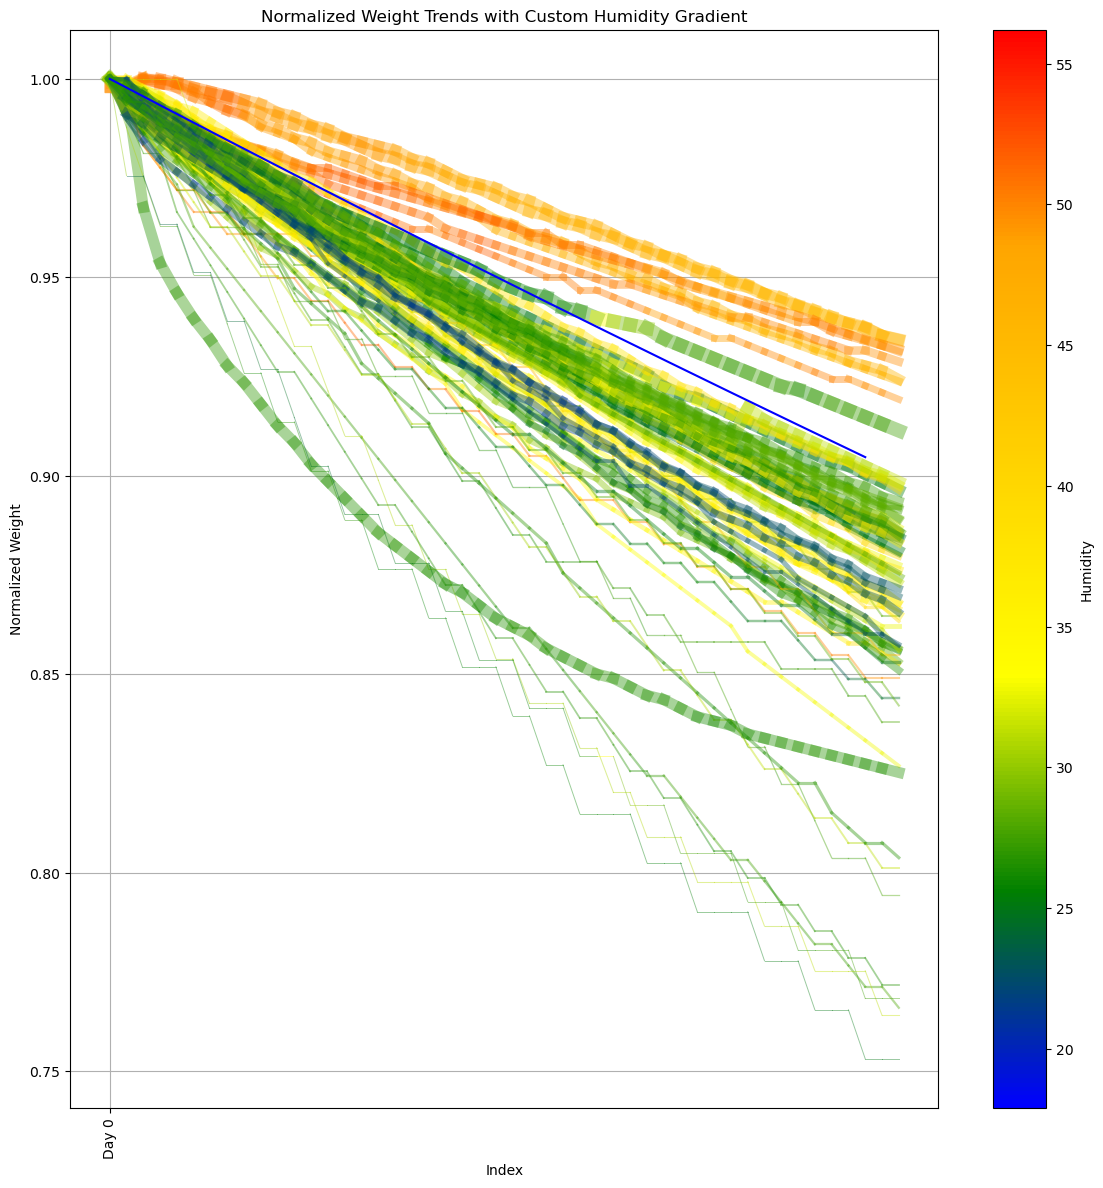

In [33]:
# Define normalization for colormap
norm = Normalize(vmin=min_humidity, vmax=max_humidity)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

fig, ax = plt.subplots(figsize=(14, 14))  # Create the main plot

# Define the range to plot (first 4 days)
start_index = 0
end_index = 1 * 48  # 4 days worth of data

# Iterate through each DataFrame and plot
for df in dfs:
    # Identify the Weight column (find column that starts with 'Weight_')
    weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
    if weight_cols:
        weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
        # Normalize the Weight column
        df['Normalized_Weight'] = (df[weight_col] / df[weight_col].max())
        
        # Normalize Humidity
        df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range min-max

        # Filter the DataFrame to include only the first 4 days
        df_filtered = df.iloc[start_index:end_index]

        # Map humidity to color
        colors = custom_cmap(norm(df_filtered['Humidity']))

        #Dot size, depends on how large the piece is
        dot_size = (df[weight_col].max()/max_weight) *10
        
        # Scatter plot with gradient colors
        #plt.scatter(df_filtered.index, df_filtered['Normalized_Weight'], c=colors, s=20, alpha=0.2, label=weight_col)
        for i in range(len(df_filtered) - 1):
            plt.plot(df_filtered.index[i:i+2], df_filtered['Normalized_Weight'].iloc[i:i+2], color=colors[i], linewidth=dot_size, alpha=0.4)

# Generate x values
x = np.linspace(0, 45, 500)  # You can adjust the range and number of points

# Compute y values
y = -np.log(x/450 + 1)+1

# Create the plot
plt.plot(x, y, label='-ln(x + 1)', color='blue')

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Humidity')

# Set x-ticks at intervals of 48
tick_positions = range(start_index, end_index, 48)
tick_labels = [f'Day {i // 48 + 0}' for i in tick_positions]

# Apply the ticks and labels to the x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=90)  # Rotate labels if needed

# Add grid
ax.grid(True)  # Adds grid lines

#ax.set_xlim(0, 1)

plt.xlabel('Index')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# Optionally add a legend
# plt.legend(title='Weight Column')

plt.show()

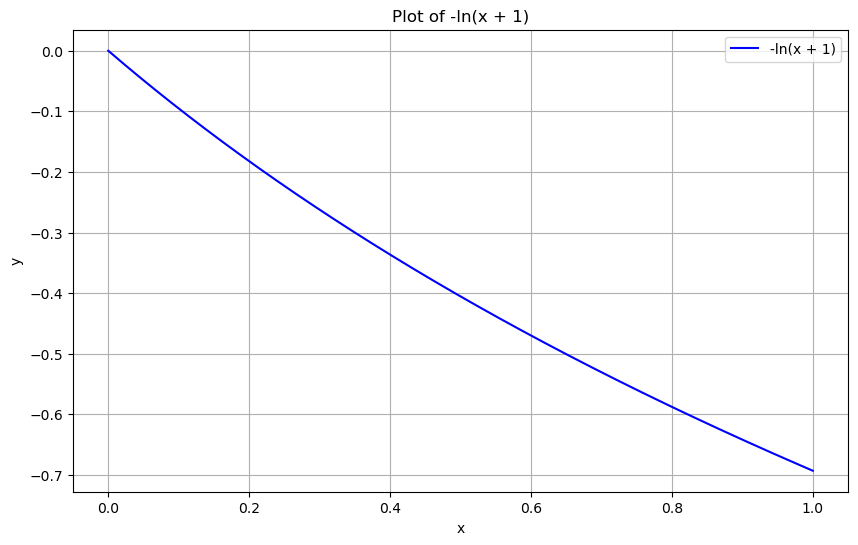

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(0, 1, 500)  # You can adjust the range and number of points

# Compute y values
y = -np.log(x + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='-ln(x + 1)', color='blue')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of -ln(x + 1)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


Shape of the largest DataFrame: (1891, 9)


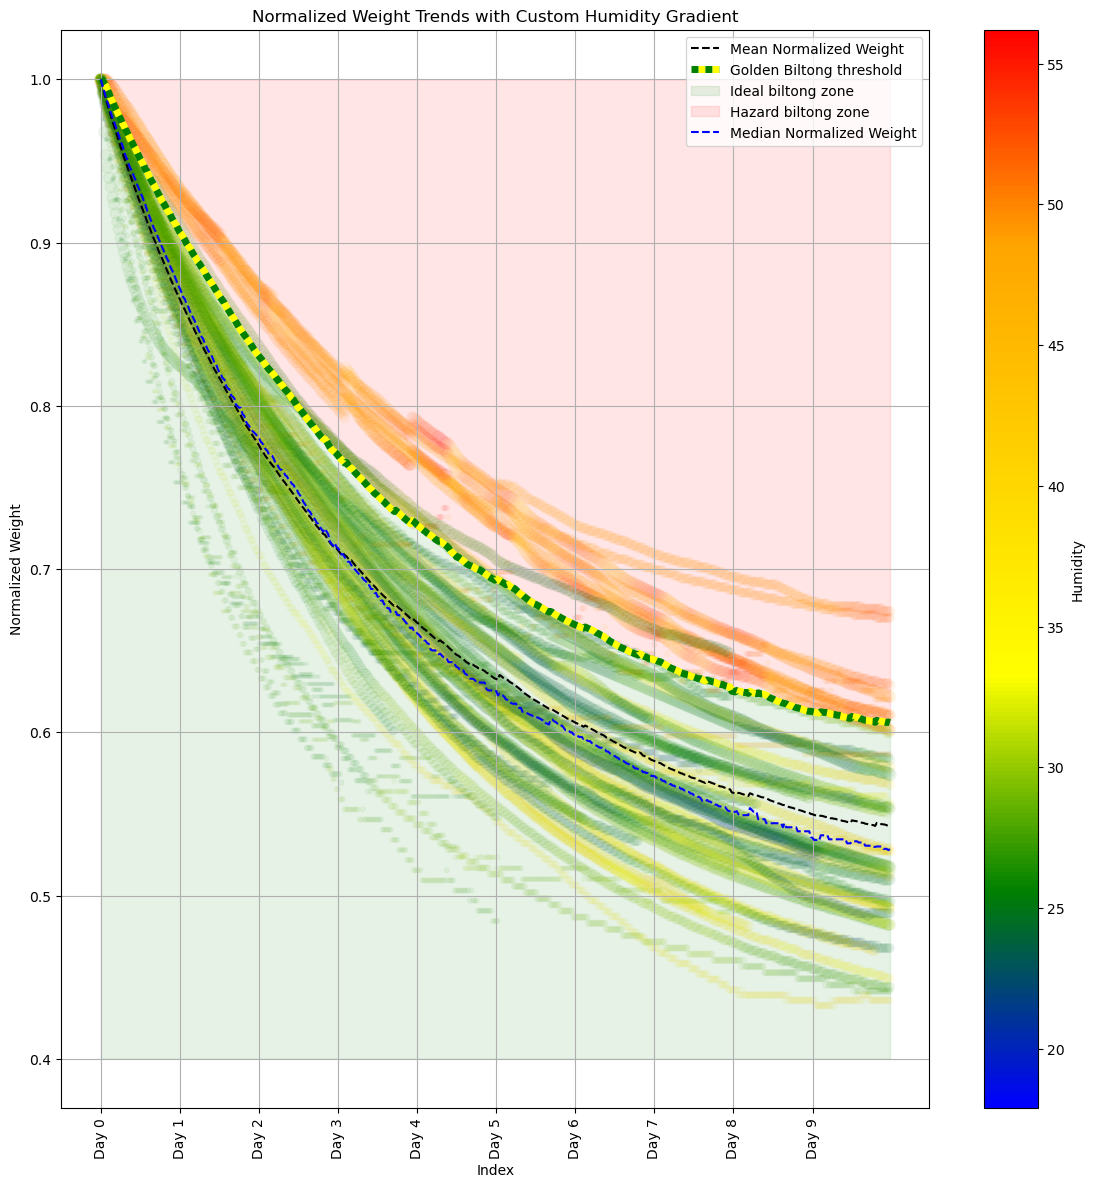

In [35]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.colors import Normalize
# import matplotlib.patches as patches
# import numpy as np

# # Define normalization for colormap
# norm = Normalize(vmin=min_humidity, vmax=max_humidity)

# # Create a ScalarMappable for the colorbar
# sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
# sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

# fig, ax = plt.subplots(figsize=(14, 14))  # Create the main plot

# # Create a new DataFrame to store normalized weights
# all_normalized_weights = pd.DataFrame()

# # Define the range to plot (first 4 days)
# start_index = 0
# end_index = 10 * 48  # 4 days worth of data

# # Iterate through each DataFrame and plot
# for df in dfs:
#     # Identify the Weight column (find column that starts with 'Weight_')
#     weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
#     if weight_cols:
#         weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
#         # Normalize the Weight column
#         df['Normalized_Weight'] = (df[weight_col] / df[weight_col].max())
        
#         # Normalize Humidity
#         df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range min-max

#         # Filter the DataFrame to include only the first 4 days
#         df_filtered = df.iloc[start_index:end_index]

#         # Add normalized weight to the new DataFrame
#         all_normalized_weights = pd.concat([all_normalized_weights, df[['Normalized_Weight']]], axis=1)

#         # Map humidity to color
#         colors = custom_cmap(norm(df_filtered['Humidity']))

#         # Dot size, depends on how large the piece is
#         dot_size = (df[weight_col].max()/max_weight) * 80
        
#         # Scatter plot with gradient colors
#         plt.scatter(df_filtered.index, df_filtered['Normalized_Weight'], c=colors, s=dot_size, alpha=0.05, label=weight_col)

# # Add colorbar
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
# cbar.set_label('Humidity')

# # Add transparent green box
# # green_rect = patches.Rectangle(
# #     (0, 0.4),  # Bottom-left corner (x, y)
# #     end_index,  # Width (number of ticks for 5 days)
# #     0.2,     # Height
# #     linewidth=1, edgecolor='none', facecolor='green', alpha=0.3)  # Adjust transparency with alpha
# # ax.add_patch(green_rect)

# # Add transparent orange box
# # orange_limit_start = 48 * 8
# # orange_rect = patches.Rectangle(
# #     (orange_limit_start, 0.6),  # Bottom-left corner (x, y)
# #     end_index - orange_limit_start,  # Width (number of ticks for 5 days)
# #     0.4,     # Height
# #     linewidth=1, edgecolor='none', facecolor='red', alpha=0.2)  # Adjust transparency with alpha
# # ax.add_patch(orange_rect)

# # Adding the green horizontal line
# # ax.hlines(xmin=0*48, xmax=8*48, y=0.6, color='green', linestyle='-', linewidth=5, label='Threshold Line')
# # ax.hlines(xmin=8*48, xmax=end_index, y=0.6, color='red', linestyle='-', linewidth=5, label='Threshold Line')

# # Set x-ticks at intervals of 48
# tick_positions = range(start_index, end_index, 48)
# tick_labels = [f'Day {i // 48 + 0}' for i in tick_positions]

# # Apply the ticks and labels to the x-axis
# ax.set_xticks(tick_positions)
# ax.set_xticklabels(tick_labels, rotation=90)  # Rotate labels if needed

# # Add grid
# ax.grid(True)  # Adds grid lines

# # Set y-axis to logarithmic scale
# # ax.set_yscale('log')

# plt.xlabel('Index')
# plt.ylabel('Normalized Weight')
# plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# # Find the DataFrame with the most rows
# df_filtered = max(dfs, key=lambda df: df.shape[0])

# # Print the shape of the largest DataFrame to confirm
# print("Shape of the largest DataFrame:", df_filtered.shape)
# df_filtered = df_filtered.iloc[start_index:end_index]

# # Calculate and plot statistics
# if not all_normalized_weights.empty:
#     # Ensure the index is aligned for statistics calculation
#     aligned_weights = all_normalized_weights.reindex(df_filtered.index)
#     #aligned_weights = all_normalized_weights
    
#     mean_weights = aligned_weights.mean(axis=1)
#     std_weights = aligned_weights.std(axis=1)
#     median_weights = aligned_weights.median(axis=1)
    
#     # Plot mean and std deviation
#     ax.plot(df_filtered.index, mean_weights, color='black', linestyle='--', label='Mean Normalized Weight')
#     #ax.plot(df_filtered.index, mean_weights + std_weights, color='yellow', linestyle='-', label='Golden Biltong line', linewidth=5)
#      # Create a checkered pattern for the "Golden Biltong line"
#     segment_length = 12  # Adjust segment length to control stripe size
#     colors = ['yellow', 'green']
    
#     for i in range(0, len(df_filtered.index), segment_length):
#         start_idx = i
#         end_idx = min(i + segment_length, len(df_filtered.index))
#         color = colors[(i // segment_length) % 2]
#         ax.plot(df_filtered.index[start_idx:end_idx], mean_weights[start_idx:end_idx]+std_weights[start_idx:end_idx], color=color, linestyle='-', linewidth=5, label='Golden Biltong threshold' if start_idx == 0 else "")


#     ax.fill_between(df_filtered.index, 0.4, mean_weights + std_weights, color='green', alpha=0.1, label='Ideal biltong zone')
#     ax.fill_between(df_filtered.index, mean_weights + std_weights, 1, color='red', alpha=0.1, label='Hazard biltong zone')

#     # Plot median and std deviation
#     ax.plot(df_filtered.index, median_weights, color='blue', linestyle='--', label='Median Normalized Weight')

# # # Only show legend for Mean, Median, and Std Dev
# # handles, labels = ax.get_legend_handles_labels()
# # # Filter out only the statistics
# # filtered_handles = [handle for handle, label in zip(handles, labels) if label in ['Mean Normalized Weight', 'Median Normalized Weight', 'Ideal biltong zone','Golden Biltong threshold','Hazard biltong zone']]
# # filtered_labels = [label for label in labels if label in ['Mean Normalized Weight', 'Median Normalized Weight', 'Ideal biltong zone','Golden Biltong threshold','Hazard biltong zone']]
# # ax.legend(filtered_handles, filtered_labels)

# # Custom legend handle for striped pattern
# stripe_handle = Line2D([0], [0], color='black', linestyle='--', linewidth=5, label='Golden Biltong threshold')
# # Add custom legend entry
# handles, labels = ax.get_legend_handles_labels()
# handles.append(stripe_handle)
# labels.append('Golden Biltong threshold')

# # Only show legend for Mean, Median, and Std Dev, plus the custom handle
# filtered_handles = [handle for handle, label in zip(handles, labels) if label in ['Mean Normalized Weight', 'Median Normalized Weight', 'Ideal biltong zone', 'Golden Biltong threshold', 'Hazard biltong zone']]
# filtered_labels = [label for label in labels if label in ['Mean Normalized Weight', 'Median Normalized Weight', 'Ideal biltong zone', 'Golden Biltong threshold', 'Hazard biltong zone']]
# ax.legend(filtered_handles, filtered_labels)

# plt.show()

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.patches as patches
import numpy as np
from matplotlib.lines import Line2D

# Define normalization for colormap
norm = Normalize(vmin=min_humidity, vmax=max_humidity)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

fig, ax = plt.subplots(figsize=(14, 14))  # Create the main plot

# Create a new DataFrame to store normalized weights
all_normalized_weights = pd.DataFrame()

# Define the range to plot (first 4 days)
start_index = 0
end_index = 10 * 48  # 4 days worth of data

# Iterate through each DataFrame and plot
for df in dfs:
    # Identify the Weight column (find column that starts with 'Weight_')
    weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
    if weight_cols:
        weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
        # Normalize the Weight column
        df['Normalized_Weight'] = (df[weight_col] / df[weight_col].max())
        
        # Normalize Humidity
        df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range min-max

        # Filter the DataFrame to include only the first 4 days
        df_filtered = df.iloc[start_index:end_index]

        # Add normalized weight to the new DataFrame
        all_normalized_weights = pd.concat([all_normalized_weights, df[['Normalized_Weight']]], axis=1)

        # Map humidity to color
        colors = custom_cmap(norm(df_filtered['Humidity']))

        # Dot size, depends on how large the piece is
        dot_size = (df[weight_col].max()/max_weight) * 80
        
        # Scatter plot with gradient colors
        plt.scatter(df_filtered.index, df_filtered['Normalized_Weight'], c=colors, s=dot_size, alpha=0.05, label=weight_col)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Humidity')

# Set x-ticks at intervals of 48
tick_positions = range(start_index, end_index, 48)
tick_labels = [f'Day {i // 48 + 0}' for i in tick_positions]

# Apply the ticks and labels to the x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=90)  # Rotate labels if needed

# Add grid
ax.grid(True)  # Adds grid lines

plt.xlabel('Index')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# Find the DataFrame with the most rows
df_filtered = max(dfs, key=lambda df: df.shape[0])

# Print the shape of the largest DataFrame to confirm
print("Shape of the largest DataFrame:", df_filtered.shape)
df_filtered = df_filtered.iloc[start_index:end_index]

# Calculate and plot statistics
if not all_normalized_weights.empty:
    # Ensure the index is aligned for statistics calculation
    aligned_weights = all_normalized_weights.reindex(df_filtered.index)
    
    mean_weights = aligned_weights.mean(axis=1)
    std_weights = aligned_weights.std(axis=1)
    median_weights = aligned_weights.median(axis=1)
    
    # Plot mean and std deviation
    ax.plot(df_filtered.index, mean_weights, color='black', linestyle='--', label='Mean Normalized Weight')
    
    ax.plot(df_filtered.index, mean_weights + std_weights, color='green', linestyle='-', linewidth=5,dashes=[1, 1], gapcolor='yellow', label ='Golden Biltong threshold')
    #ax.plot(df_filtered.index, mean_weights + std_weights, color='yellow', linestyle='--', linewidth=5)
 
    ax.fill_between(df_filtered.index, 0.4, mean_weights + std_weights, color='green', alpha=0.1, label='Ideal biltong zone')
    ax.fill_between(df_filtered.index, mean_weights + std_weights, 1, color='red', alpha=0.1, label='Hazard biltong zone')

    # Plot median and std deviation
    ax.plot(df_filtered.index, median_weights, color='blue', linestyle='--', label='Median Normalized Weight')

# # Custom legend handle for striped pattern
# stripe_handle_1 = Line2D([], [], color='green', linestyle="--", dashes=(1, 1), linewidth=5)
# stripe_handle_2 = Line2D([], [], color='yellow', linestyle="--", dashes=(1, 2), linewidth=5)

# # Add custom legend entries
handles, labels = ax.get_legend_handles_labels()
# handles.append(stripe_handle_1)
# handles.append(stripe_handle_2)
# labels.append("Golden Biltong threshold")

# Only show legend for Mean, Median, and Std Dev, plus the custom handle
filtered_handles = [handle for handle, label in zip(handles, labels) if label in ['Mean Normalized Weight', 'Median Normalized Weight', 'Ideal biltong zone', 'Hazard biltong zone', 'Golden Biltong threshold']]
filtered_labels = [label for label in labels if label in ['Mean Normalized Weight', 'Median Normalized Weight', 'Ideal biltong zone', 'Hazard biltong zone', 'Golden Biltong threshold']]

ax.legend(filtered_handles, filtered_labels)
plt.show()



In [36]:
try:
    client
except NameError:
    print("No dask client defined, nothing to shut down.")
else:
    print("Shutting down the Dask client.")
    client.close()
    del client

Shutting down the Dask client.
